# import

In [1]:
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr#

In [130]:
import pandas as pd
import numpy as np
import os
import sys
from time import time



from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy import constants 
from astropy.coordinates import SkyCoord
from astropy.visualization import hist
from astroML.datasets import fetch_imaging_sample, fetch_sdss_S82standards
from astroML.crossmatch import crossmatch_angular

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import cm

import os
from collections import OrderedDict
from adjustText import adjust_text

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [5]:
from adjustText import adjust_text
import matplotlib as mpl
def set_ax_tick(ax):
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',)
    ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')

def set_ax_locator(ax,xma=1,xmi=0.2,yma=1,ymi=0.2):
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(xma))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(xmi))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yma))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(ymi)) 

In [ ]:
colors_10 = cm.get_cmap('tab10', 10)

In [6]:
def drop_index(data):
    data=data.reset_index(drop=True)
    return data

## cosmology

In [7]:

from astropy.cosmology import FlatLambdaCDM,Planck13,Planck15,z_at_value
from astropy import units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
#cosmo=FlatLambdaCDM(H0=73,Om0=0.3)

## CLAGN_list_2020

In [ ]:
CLAGN_list_2020=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/clagn_ned_list_20210201.xlsx',sheet_name='工作表1')
CLAGN_list_2020=CLAGN_list_2020[1:]

CLAGN_list_2020.replace(to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)
CLAGN_list_2020=CLAGN_list_2020[CLAGN_list_2020['     RA     '].notnull()]

CLAGN_list_2020=CLAGN_list_2020.reset_index(drop=True)

CLAGN_list_2020_coord=SkyCoord(ra=CLAGN_list_2020['     RA     '], dec=CLAGN_list_2020['    DEC  '], frame='icrs')

In [ ]:
CLAGN_list_2020.columns

In [ ]:
len(CLAGN_list_2020)

CLAGN_list_2020['     RA     ']

CLAGN_list_2020['    DEC  ']

## CLAGN_list_2021_liu

In [8]:
CLAGN_list_2021_liu=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/CLAGN_with_RA_Dec_Liuhaov2.xlsx',sheet_name='sources')
#CLAGN_list_2021_liu=CLAGN_list_2020[1:]
CLAGN_list_2021_liu.replace(to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)
CLAGN_list_2021_liu=CLAGN_list_2021_liu[CLAGN_list_2021_liu['RA'].notnull()]
CLAGN_list_2021_liu=CLAGN_list_2021_liu.reset_index(drop=True)
CLAGN_list_2021_liu_coord=SkyCoord(ra=CLAGN_list_2021_liu['RA'], dec=CLAGN_list_2021_liu['DEC'], frame='icrs')
CLAGN_list_2021_liu['ra_deg']=CLAGN_list_2021_liu_coord.ra.deg
CLAGN_list_2021_liu['dec_deg']=CLAGN_list_2021_liu_coord.dec.deg

In [9]:
CLAGN_list_2021_liu.columns

Index(['Name', 'Unnamed: 1', 'RA', 'DEC', 'Ref.', 'Redshift', 'lg(MBH/Msun)',
       'Ref..1', 'Type', 'Note', 'Unnamed: 10', 'FIRST', 'ra_deg', 'dec_deg'],
      dtype='object')

In [10]:
len(CLAGN_list_2021_liu)

141

# FIRST

In [ ]:
FIRST=fits.open('/Volumes/ExtremeSSD/Papers_Project/mwa_catalog_paper/catalog/first_14dec17.fits')

In [ ]:
FIRST_data=FIRST[1].data

In [ ]:
FIRST[1].data.columns

FIRST_coord=SkyCoord(ra=FIRST[1].data['RA'], dec=FIRST[1].data['DEC'], frame='icrs')

## crossmatch

imX = np.empty((len(CLAGN_list_2020_coord), 2), dtype=np.float64)
imX[:, 0] = CLAGN_list_2020_coord.ra.deg
imX[:, 1] = CLAGN_list_2020_coord.dec.deg

stX = np.empty((len(FIRST_data), 2), dtype=np.float64)
stX[:, 0] = FIRST_data['RA']
stX[:, 1] = FIRST_data['DEC']


#crossmatch catalogs
#max_radius = 1. / 3600  # 1 arcsec
#max_radius = 5  # 1 degree
max_radius = 10. / 3600  # 60 arcsec

dist, ind = crossmatch_angular(imX, stX, max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

ax = plt.axes()
hist(dist_match, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 10)
plt.show()


In [ ]:
ind[match]

In [ ]:
30/141

In [ ]:
18/68

## CLAGN_list_2021_liu_coord

In [ ]:
crosslist=CLAGN_list_2021_liu_coord
imX = np.empty((len(CLAGN_list_2021_liu_coord), 2), dtype=np.float64)
imX[:, 0] = CLAGN_list_2021_liu_coord.ra.deg
imX[:, 1] = CLAGN_list_2021_liu_coord.dec.deg

stX = np.empty((len(FIRST_data), 2), dtype=np.float64)
stX[:, 0] = FIRST_data['RA']
stX[:, 1] = FIRST_data['DEC']


# crossmatch catalogs
#max_radius = 1. / 3600  # 1 arcsec
#max_radius = 5  # 1 degree
max_radius = 10. / 3600  # 60 arcsec

dist, ind = crossmatch_angular(imX, stX, max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

ax = plt.axes()
hist(dist_match, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 5)
plt.show()


## counts match

In [ ]:
crosslist=CLAGN_list_2021_liu_coord
imX = np.empty((len(CLAGN_list_2021_liu_coord), 2), dtype=np.float64)
imX[:, 0] = CLAGN_list_2021_liu_coord.ra.deg
imX[:, 1] = CLAGN_list_2021_liu_coord.dec.deg

stX = np.empty((len(FIRST_data), 2), dtype=np.float64)
stX[:, 0] = FIRST_data['RA']
stX[:, 1] = FIRST_data['DEC']


# crossmatch catalogs
#max_radius = 1. / 3600  # 1 arcsec
#max_radius = 5  # 1 degree
max_radius = 5. / 3600  # 60 arcsec

dist, ind = crossmatch_angular(stX, imX, max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

ax = plt.axes()
hist(dist_match, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 5)
plt.show()

In [ ]:
from collections import Counter
ind_remove_rep_FIRST=[]

for i in ind[match]:
    if i not in ind_remove_rep_FIRST:
        ind_remove_rep_FIRST.append(i)
        
ind_remove_rep_FIRST=np.array(ind_remove_rep_FIRST)        
a_FIRST=Counter(ind[match])

In [ ]:
a_FIRST,ind_remove_rep_FIRST

In [ ]:
CLAGN_list_2021_liu['Name'][ind_remove_rep_FIRST[np.arange(len(ind_remove_rep_FIRST))]].str.strip()

In [ ]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(111)

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(ind_remove_rep_FIRST)))

for index,i in enumerate(a_FIRST):#index 
    plt.bar(index,a_FIRST[i],color=colors[index])
    #print(index,i,a[i])
    
plt.xticks(np.arange(len(ind_remove_rep_FIRST)),CLAGN_list_2021_liu['Name'][ind_remove_rep_FIRST[np.arange(len(ind_remove_rep_FIRST))]].str.strip(),rotation=90)
#plt.title('within 5degree')
##plt.show()

## plot_flux

In [ ]:
FIRST_data_copy=FIRST_data.copy()
new_table_CLAGN=FIRST_data_copy[match]
new_index=ind[match]
#new_table_CLAGN=FIRST_data_copy.reset_index(drop=True)

new_table_CLAGN.columns

new_table_CLAGN['RA'],new_table_CLAGN['DEC'],new_table_CLAGN['FINT']

## CLAGN_list_2021_liu_name_pos

In [ ]:
CLAGN_list_2021_liu_name_pos=CLAGN_list_2021_liu[['Name','ra_deg','dec_deg']]

In [ ]:
CLAGN_list_2021_liu_name_pos[CLAGN_list_2021_liu_name_pos['Name']=='PG 1535+547']

In [ ]:
for index,i in enumerate(new_index):
    print(index,i,CLAGN_list_2021_liu['Name'][i],CLAGN_list_2021_liu_name_pos['ra_deg'][i],CLAGN_list_2021_liu_name_pos['dec_deg'][i],new_table_CLAGN['FINT'][index])

for index,i in enumerate(new_index):
    print(index,i,CLAGN_list_2021_liu['Name'][i],new_table_CLAGN['RA'][index],new_table_CLAGN['DEC'][index],new_table_CLAGN['FINT'][index])

In [ ]:
fig=plt.figure(figsize=(20,6))
ax=fig.add_subplot(111)

for index,i in enumerate(new_index):
    plt.bar(index,new_table_CLAGN['FINT'][index])
    #print(index,i,a[i])
    plt.text(index-0.5,new_table_CLAGN['FINT'][index],'%.1f'%new_table_CLAGN['FINT'][index])
    
plt.xticks(np.arange(len(new_index)),CLAGN_list_2021_liu['Name'][new_index[np.arange(len(new_index))]].str.strip(),rotation=90)
plt.ylabel('FINT(mJy)')
#plt.title('within 5degree')
plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/Flux_FIRST_CLAGN_crossmatch.png',dpi=400,transparent=False,bbox_inches='tight')
#plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/AGN_num_within5degree.png',dpi=400,transparent=False,bbox_inches='tight')

#plt.show()

In [ ]:
CLAGN_list_2021_liu_name_pos[CLAGN_list_2021_liu_name_pos['Name']=='NGC 7469']

## format print

print('{0:>15},{1:.2f},{2:.2f},{3:.2f},{4:.1f},{5:.2f}'.format(obs_id,float(powerlawindex),float(gerr90),float(indexerr),float(bins),float(rechied))+'\n')
print('{0:.2e},{1:.2e},{2:.2e},{3:.2e}'.format(float(flux),float(ferr),float(cflux_),float(cflux_err90))+'\n')


In [ ]:
print("{0:<30},{1:<5},{2:<5},{3:<5},{4:<5},{5:<5}".format('Name','Redshift','lg(MBH/Msun)','RA','DEC','FINT'))
for index,i in enumerate(new_index):
    print("{0:<30},{1:.5f},{2:.2f},{3:.5f},{4:.5f},{5:.3F}".format(CLAGN_list_2021_liu['Name'][i],CLAGN_list_2021_liu['Redshift'][i],CLAGN_list_2021_liu['lg(MBH/Msun)'][i],new_table_CLAGN['RA'][index],new_table_CLAGN['DEC'][index],new_table_CLAGN['FINT'][index]))
    #data_format = '{0:>15},{1:%.5f},{2:%.5f},{3:%.5f},{4:%.3f}'.format(CLAGN_list_2021_liu['Name'][i],CLAGN_list_2021_liu['Redshift'][i],new_table_CLAGN['RA'][index],new_table_CLAGN['DEC'][index],new_table_CLAGN['FINT'][index])
    #print(data_format)
    #print(index,',',i,',',CLAGN_list_2021_liu['Name'][i],',',CLAGN_list_2021_liu['Redshift'][i],',',new_table_CLAGN['RA'][index],',',new_table_CLAGN['DEC'][index],',',new_table_CLAGN['FINT'][index])

for index,i in enumerate(new_index):
    #print('{0:<30},{1:.5f},{2:.5f},{3:.5f},{4:.3f}'.format(CLAGN_list_2021_liu['Name'][i],CLAGN_list_2021_liu['Redshift'][i],new_table_CLAGN['RA'][index],new_table_CLAGN['DEC'][index],new_table_CLAGN['FINT'][index]))
    data_format = '{0:<30},{1:.5f},{2:.5f},{3:.5f},{4:.3f}'.format(CLAGN_list_2021_liu['Name'][i],CLAGN_list_2021_liu['Redshift'][i],new_table_CLAGN['RA'][index],new_table_CLAGN['DEC'][index],new_table_CLAGN['FINT'][index])
    print(data_format)
    #print(index,',',i,',',CLAGN_list_2021_liu['Name'][i],',',CLAGN_list_2021_liu['Redshift'][i],',',new_table_CLAGN['RA'][index],',',new_table_CLAGN['DEC'][index],',',new_table_CLAGN['FINT'][index])

## CLAGN_X-ray FLUX

### Lbol

## FIRST_flux

In [ ]:
FIRST_crossmatch=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/CLAGN_with_RA_Dec_Liuhaov2.xlsx',sheet_name='FIRST')
#CLAGN_list_2021_liu=CLAGN_list_2020[1:]

In [ ]:
FIRST_crossmatch

In [ ]:
D_cm=cosmo.luminosity_distance(z=FIRST_crossmatch['Redshift']).to(u.cm)
FIRST_crossmatch['D_cm']=D_cm

1Jy = 10-23erg/cm2/s/Hz

In [ ]:
FIRST_crossmatch['L_INT']=4*np.pi*FIRST_crossmatch['D_cm']**2*FIRST_crossmatch['FINT']*1e-26*1.4*1e9

In [ ]:
FIRST_crossmatch.columns

In [ ]:
ax.axhline?

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

for i in range(len(FIRST_crossmatch)):        
    if not pd.isnull(FIRST_crossmatch.iloc[i]['logLxmax']):

plt.hist(FIRST_crossmatch['Redshift'])

plt.hist(FIRST_crossmatch['L_INT'],bins=5)

In [ ]:
'''            print(np.log10(FIRST_crossmatch.iloc[i]['L_INT']),
                  FIRST_crossmatch.iloc[i]['logLx'],
                  FIRST_crossmatch.iloc[i]['logLxmax'])'''

In [ ]:
FIRST_crossmatch_select=FIRST_crossmatch[FIRST_crossmatch['logLx'].notnull()]
FIRST_crossmatch_select=FIRST_crossmatch_select.reset_index(drop=True)

In [ ]:
FIRST_crossmatch_select

In [ ]:
from adjustText import adjust_text

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

for i in range(len(FIRST_crossmatch)):
    if not pd.isnull(FIRST_crossmatch.iloc[i]['logLx']):      
        if pd.isnull(FIRST_crossmatch.iloc[i]['logLxmax']):
            ax.scatter(FIRST_crossmatch.iloc[i]['logLx'],np.log10(FIRST_crossmatch.iloc[i]['L_INT'])                ,
            #ec='red',fc="red",
            marker='.',   
            color='red',)
        else:

            ax.hlines(y=np.log10(FIRST_crossmatch.iloc[i]['L_INT']),
                       xmin=FIRST_crossmatch.iloc[i]['logLx'],
                       xmax=FIRST_crossmatch.iloc[i]['logLxmax'],
                       color='blue',
                       #linestyle=':'
                     )          
        ax.text(FIRST_crossmatch.iloc[i]['logLx'],
            np.log10(FIRST_crossmatch.iloc[i]['L_INT']),
            FIRST_crossmatch.iloc[i]['Name                          '])

'''texts = [ax.text(FIRST_crossmatch_select['logLx'][i], np.log10(FIRST_crossmatch_select['L_INT'][i]),
                 FIRST_crossmatch_select['Name                          '][i],fontsize=9,) for i in range(len(FIRST_crossmatch_select))]

adjust_text(texts,ax=ax,#arrowprops=dict(arrowstyle='->', color='red',lw=0.5),
            expand_text=(1.25,1.3),
            expand_points=(1.25,1.3),
            expand_objects=(1.25, 1.3),
            expand_align=(1.25, 1.3),
            autoalign='xy',
           #only_move={'points':'x', 'text':'x'}
           ) #使用adjust_text
'''
        
        
ax.set_xlabel('log LX')
ax.set_ylabel(r'log LR(1.4GHz)')

#ax.set_xlim(0.5,2.5)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
#ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.1, 0.8),ncol=1,loc=2,fontsize=10)

plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/CLAGN_RX.png', 
            dpi=400, transparent=False, bbox_inches='tight')
        
        

# BAT

In [11]:
BAT_105m_Seyfert=pd.read_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/BAT_105m_Seyfert_data.csv')
print(BAT_105m_Seyfert.columns)

Index(['Seq', '---', 'Swift', 'RAdeg', 'DEdeg', 'S/N', 'CName', 'RACdeg',
       'DECdeg', 'Flux', 'e_Flux', 'E_Flux', 'Gamma', 'e_Gamma', 'E_Gamma',
       'Chi2', 'z', 'logL', 'Class', 'Type', 'S_type'],
      dtype='object')


In [ ]:
len(BAT_105m_Seyfert)

## Crossmatch

In [ ]:
imX = np.empty((len(CLAGN_list_2021_liu_coord), 2), dtype=np.float64)
imX[:, 0] = CLAGN_list_2021_liu_coord.ra.deg
imX[:, 1] = CLAGN_list_2021_liu_coord.dec.deg

stX = np.empty((len(BAT_105m_Seyfert), 2), dtype=np.float64)
stX[:, 0] = pd.to_numeric(BAT_105m_Seyfert['RAdeg'])
stX[:, 1] = pd.to_numeric(BAT_105m_Seyfert['DEdeg'])


# crossmatch catalogs
#max_radius = 1. / 3600  # 1 arcsec
#max_radius = 5  # 1 degree
max_radius = 60. / 3600  # 60 arcsec

dist, ind = crossmatch_angular(stX, imX, max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

ax = plt.axes()
hist(dist_match, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (imX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)
ax.set_xlim(0, 60)
plt.show()

In [ ]:
from collections import Counter

ind_remove_rep_BAT=[]
for i in ind[match]:
    if i not in ind_remove_rep_BAT:
        ind_remove_rep_BAT.append(i)
        
ind_remove_rep_BAT=np.array(ind_remove_rep_BAT)        
a_BAT=Counter(ind[match])

In [ ]:
ind_remove_rep_BAT

In [ ]:
CLAGN_statistic_2021_liu[:5]

In [ ]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(111)

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(ind_remove_rep_BAT)))

for index,i in enumerate(a_BAT):#index 
    plt.bar(index,a_BAT[i],color=colors[index])
    #print(index,i,a[i])
plt.xticks(np.arange(len(ind_remove_rep_BAT)),CLAGN_list_2021_liu['Name'][ind_remove_rep_BAT[np.arange(len(ind_remove_rep_BAT))]].str.strip(),rotation=90)
plt.show()

# CLAGN_statistic_2021_liu

In [13]:
CLAGN_statistic_2021_liu=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/CLAGN_with_RA_Dec_Liuhaov2.xlsx',sheet_name='statistic_paper',header=None)
#CLAGN_list_2021_liu=CLAGN_list_2020[1:]
CLAGN_statistic_2021_liu.columns=['Name','z','type1or2','type','ref1','logM','ref2','']
#CLAGN_statistic_2021_liu
namelists_CLAGN_statistic_2021_liu=CLAGN_statistic_2021_liu['Name']

In [14]:
CLAGN_statistic_2021_liu[:5]

Name      z     type1or2 type  ref1  logM       ref2    
0  1ES 1927+654   0.017          NaN   A     -1   7.3   (2)   \\ NaN
1   1H 0419-577   0.104  Seyfert 1.5   B     -3  8.58   (4)   \\ NaN
2      3C 390.3   0.056          NaN   A     -5    -       -  \\ NaN
3   ESO 362-G18   0.012          NaN   A     -6  7.65   (7)   \\ NaN
4     Fairall 9   0.046          NaN   A     -5  8.41   (8)   \\ NaN

CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['Name']=='NGC1068']

print(len(namelists_CLAGN_statistic_2021_liu))
for i in namelists_CLAGN_statistic_2021_liu[:]:
    print(i.replace(' ',''))

## Leddrate

In [92]:
CLAGN_statistic_2021_liu_Leddrate=pd.read_excel('/Users/brettlv/blog/IHEP_sync/data/data_clagn/CLAGN_with_RA_Dec.xlsx',sheet_name='EddingtonRatio',header=0)

In [93]:
len(CLAGN_statistic_2021_liu_Leddrate)

647

In [94]:
CLAGN_statistic_2021_liu_Leddrate.columns

Index(['Name', 'Flux', 'Unnamed: 2', 'L', 'Unnamed: 4', 'F2-10', 'L2-10',
       'Flux.1', 'Unnamed: 8', 'L.1', 'Unnamed: 10', 'L5100', 'Lbol', 'MBH',
       'LEdd', 'Lbol/LEdd', 'Unnamed: 16', 'lgLbol/LEdd', 'Unnamed: 18'],
      dtype='object')

In [18]:
CLAGN_statistic_2021_liu_Leddrate[:5]

Name  Flux Unnamed: 2   L Unnamed: 4  F2-10  L2-10  Flux.1  \
0  1ES 1927+654   NaN        NaN NaN        NaN    NaN    NaN     NaN   
1           NaN   NaN        NaN NaN        NaN    NaN  42.38     NaN   
2           NaN   NaN        NaN NaN        NaN    NaN    NaN     NaN   
3   1H 0419-577   NaN        NaN NaN        NaN    NaN  44.93     NaN   
4           NaN   NaN        NaN NaN        NaN    NaN  44.83     NaN   

  Unnamed: 8  L.1 Unnamed: 10  L5100     Lbol  MBH       LEdd  Lbol/LEdd  \
0        NaN  NaN         NaN  42.98      NaN  NaN        NaN   0.030000   
1        NaN  NaN         NaN    NaN      NaN  NaN        NaN   0.110000   
2        NaN  NaN         NaN    NaN      NaN  NaN        NaN   0.005888   
3        NaN  NaN         NaN    NaN  46.1341  NaN  46.693943   0.275535   
4        NaN  NaN         NaN    NaN  46.0341  NaN  46.693943   0.218865   

  Unnamed: 16  lgLbol/LEdd       Unnamed: 18  
0         NaN    -1.522879  arxiv:1903.11084  
1         NaN    -0.958607   arxiv:1304.7155  
2         NaN    -2.230000   arxiv:1012.1865  
3         NaN    -0.559823  arxiv:1802.00795  
4         NaN    -0.659823               NaN

In [96]:
for index,name in enumerate(range(len(CLAGN_statistic_2021_liu_Leddrate))):
    if isinstance(CLAGN_statistic_2021_liu_Leddrate.loc[index,'Name'], str):    #True    
        CLAGN_statistic_2021_liu_Leddrate.loc[index,'Name']=CLAGN_statistic_2021_liu_Leddrate.loc[index,'Name']
    else:
        CLAGN_statistic_2021_liu_Leddrate.loc[index,'Name']=CLAGN_statistic_2021_liu_Leddrate.loc[index-1,'Name']

In [97]:
CLAGN_statistic_2021_liu_Leddrate[['Name','lgLbol/LEdd']][:5]

Name  lgLbol/LEdd
0  1ES 1927+654    -1.522879
1  1ES 1927+654    -0.958607
2  1ES 1927+654    -2.230000
3   1H 0419-577    -0.559823
4   1H 0419-577    -0.659823

In [98]:
len(CLAGN_statistic_2021_liu)

141

In [99]:
CLAGN_statistic_2021_liu

Name      z     type1or2 type  ref1  logM  \
0                1ES 1927+654   0.017          NaN   A     -1   7.3   
1                 1H 0419-577   0.104  Seyfert 1.5   B     -3  8.58   
2                    3C 390.3   0.056          NaN   A     -5    -    
3                 ESO 362-G18   0.012          NaN   A     -6  7.65   
4                   Fairall 9   0.046          NaN   A     -5  8.41   
..                         ...    ...          ...  ...   ...   ...   
136  SDSS J224448.72+004347.1   0.637          NaN   A    -62   7.8   
137  SDSS J225240.37+010958.7   0.533          NaN   A    -50   8.2   
138  SDSS J233317.38-002303.4   0.513          NaN   A    -52   8.3   
139  SDSS J233602.98+001728.7   0.243          NaN   A    -52  8.26   
140  SDSS J235107.43-091318.0   0.354          NaN   A    -50   7.9   

           ref2      pearson_coeff_neo  sigma_m_w1_neo  ...  sigma_m_w2_neo  \
0      (2)   \\ NaN          -0.392109        0.103861  ...        0.934147   
1      (4)   \\ NaN           0.530280        0.017303  ...        0.000000   
2         -  \\ NaN           0.972421        0.218206  ...        0.218264   
3      (7)   \\ NaN           0.156145        0.248514  ...        0.098998   
4      (8)   \\ NaN           0.746064        0.058711  ...        0.030974   
..          ...  ..                ...             ...  ...             ...   
136   (62)   \\ NaN                NaN             NaN  ...             NaN   
137   (51)   \\ NaN                NaN             NaN  ...             NaN   
138   (51)   \\ NaN                NaN             NaN  ...             NaN   
139   (54)   \\ NaN                NaN             NaN  ...             NaN   
140   (51)   \\ NaN                NaN             NaN  ...             NaN   

     mean_m_w2_neo  len_neo  pearson_coeff_mep  sigma_m_w1_mep  mean_m_w1_mep  \
0        11.530000      4.0           0.366756        0.061776      13.052478   
1         9.860934    482.0           0.166338        0.016404      10.830919   
2         8.865694    539.0           0.636645        0.055103       9.642274   
3         9.275376    274.0           0.854126        0.072953       9.870192   
4         7.991449    247.0          -0.111975        0.000000       9.065000   
..             ...      ...                ...             ...            ...   
136            NaN      0.0                NaN             NaN            NaN   
137            NaN      0.0                NaN             NaN            NaN   
138            NaN      0.0                NaN             NaN            NaN   
139            NaN      0.0                NaN             NaN            NaN   
140            NaN      0.0                NaN             NaN            NaN   

     sigma_m_w2_mep  mean_m_w2_mep  len_mep  lg(Lbol/LEdd)  
0          0.000000      12.925609     23.0      -1.594304  
1          0.035198       9.808713    136.0      -0.718023  
2          0.028625       8.601649    168.0      -0.619789  
3          0.066163       9.177962     26.0      -2.059823  
4          0.000000       7.995226     31.0      -1.329823  
..              ...            ...      ...            ...  
136             NaN            NaN      0.0      -2.431798  
137             NaN            NaN      0.0      -1.660000  
138             NaN            NaN      0.0      -2.970000  
139             NaN            NaN      0.0      -2.900000  
140             NaN            NaN      0.0            NaN  

[141 rows x 21 columns]

# wise

from astroquery.irsa import Irsa
Irsa.list_catalogs()  

In [23]:
import os
import time
from astropy import config as _config
from astroquery.irsa import Irsa    

In [ ]:
import astroquery
print(astroquery.__version__)

In [ ]:
pwd

## download

In [ ]:
#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120

for i in namelists_CLAGN_statistic_2021_liu[:]:
    #print(i)
    search_name=i.replace(' ','')
    save_name=i

    if not os.path.exists('./CLAGN_wise_data/wise_%s_mep.csv'%i):
        print(search_name)
        Irsa.ROW_LIMIT = 1000
        Irsa.TIMEOUT = 120
        table_wise_mep=Irsa.query_region(search_name,catalog='allwise_p3as_mep',spatial='Cone',radius=10*u.arcsec,)
        table_wise_mep.write('wise_%s_mep.csv'%i, format='csv')
        time.sleep(15+np.random.randint(5,10))    
    
    if not os.path.exists('./CLAGN_wise_data/wise_%s_neo.csv'%i):
        Irsa.ROW_LIMIT = 1000
        Irsa.TIMEOUT = 120
        
        table_wise_neo=Irsa.query_region(search_name,catalog='neowiser_p1bs_psd',spatial='Cone',radius=10*u.arcsec,)  
        table_wise_neo.write('wise_%s_neo.csv'%i, format='csv')       
        time.sleep(15+np.random.randint(5,10))      


## check notdown

In [24]:
#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120

for index,i in enumerate(namelists_CLAGN_statistic_2021_liu):
    save_name=i
    search_name=i.replace(' ','')
    if  not os.path.exists('./CLAGN_wise_data/wise_%s_mep.csv'%i):
        print(index,i)
        print('***mep notdone')
        
      
    if  not os.path.exists('./CLAGN_wise_data/wise_%s_neo.csv'%i):
        print(index,i)
        print('***neo notdone')            

## check download

#Irsa.ROW_LIMIT = 1000 # value of new row limit here.
#Irsa.TIMEOUT = 120

for index,i in enumerate(namelists_CLAGN_statistic_2021_liu):
    print(index,i)
    search_name=i.replace(' ','')
    if  os.path.exists('wise_%s_mep.csv'%i):
        print('mep done')
    else:
        print('***mep notdone')
        
      
    if  os.path.exists('wise_%s_neo.csv'%i):
        print('neo done')    
    else:
        print('***neo notdone')        
        

# excess_variance

<span style="font-size:larger;">
$$\sigma_{rms}^2=\frac{1}{N\mu^2}\sum_{i=1}^{N}[(X_i-\mu)^2-\sigma_i^2]\\$$
</span>  



<span style="font-size:larger;">
    error on $\sigma_{rms}^2$
</span>  


<span style="font-size:larger;">
    
$$error_{\sigma_{rms}^2}=s_D/(\mu^2\sqrt{N})$$

</span>  

<span style="font-size:larger;">

$$s_D^2=\frac{1}{N-1}\sum_{i=1}^{N}\{[(X_i-\mu)^2-\sigma_i^2]-\sigma_{rms}^2\mu^2\}^2$$

</span> 

In [ ]:
def get_excess_variance(data,flux_label,fluxerr_label):

    mu=np.average(data[flux_label])
    mu_err=np.average(data[fluxerr_label])  
    len_flux=len(data[flux_label])

    sigma_rms_sqr2=np.sum((data[flux_label]-mu)**2-data[fluxerr_label]**2)/len_flux/mu**2
    
    sd_sqr2_err=np.sum(((data[flux_label]-mu)**2-data[fluxerr_label]**2-sigma_rms_sqr2*mu**2)**2)/(len_flux-1)
    sigma2_err=sd_sqr2_err**0.5/(mu**2*len_flux**0.5)
    
    sigma_rms=sigma_rms_sqr2**0.5
    sigma_rms_err=sigma2_err*0.5*sigma_rms_sqr2**-0.5
    
    return mu,mu_err,sigma_rms_sqr2,sigma2_err,sigma_rms,sigma_rms_err

mu,mu_err,sigma_rms_sqr2,sigma2_err,sigma_rms,sigma_rms_err=  get_excess_variance(df_157_src1000_large3,'int_flux','err_int_flux')  

## intrinsic amplitude of variability

In [ ]:
intrinsic amplitude of variability (σm)

<span style="font-size:larger;">
$$\Sigma=\sqrt{\frac{1}{N-1}\sum_{i=1}^{N}(m_i-<m>)^2\\}$$
</span>  

$$\sigma_m = \begin{cases}
\sqrt{\Sigma^{2}-\epsilon^2} ,& \, \Sigma > \epsilon \\
0 , & otherwise
\end{cases}$$


$$\epsilon^2=\frac{1}{N}\sum_{i=1}^{N}\epsilon_i^2+\epsilon_s^2$$

$$\sigma_{m\, restframe}=\sigma_m \times \sqrt{(1+z)}$$

In [25]:
def get_intrinsic_var(data,mag_label,magerr_label,epsilon_s):
    mag_mean=np.average(data[mag_label])
    length_N=len(data[mag_label])
    epsilon_square=np.average(data[magerr_label]**2)+epsilon_s**2
    Sigma_square=np.sum((data[mag_label]-mag_mean)**2)/(length_N-1)
    
    if Sigma_square>epsilon_square:
        sigma_m=np.sqrt(Sigma_square-epsilon_square)
    else:
        sigma_m=0
        
    if length_N<2:
        sigma_m=-1#print(length_N)
    return sigma_m

In [26]:
namelists_CLAGN_statistic_2021_liu[0]

'1ES 1927+654 '

## data_test

In [ ]:
CLAGN_statistic_2021_liu['Name'][0]

In [ ]:
index_test=0
print(CLAGN_statistic_2021_liu['Name'][index_test])
data_test=pd.read_csv('./CLAGN_wise_data/wise_%s_neo.csv'%CLAGN_statistic_2021_liu['Name'][index_test])

data_test=data_test[data_test['w1mpro'].notnull()]
data_test=data_test[data_test['w2mpro'].notnull()]
data_test=data_test[data_test['w1sigmpro'].notnull()]
data_test=data_test[data_test['w2sigmpro'].notnull()]
data_test=data_test[data_test['qual_frame']>5]

data_test=(data_test.loc[:, ['mjd', 'w1mpro','w2mpro',
                           'w1sigmpro','w2sigmpro',                    
                           ]].sort_values('mjd'))

data_test=data_test.reset_index(drop=True)

In [ ]:
data_test.columns

In [ ]:
data_test

data_test=data_test.fillna(0)

In [ ]:
and took the values of the W1 magnitude w1mpro ep, W1 magnitude error
w1sigmpro ep, W2 magnitude w2mpro ep, W2 magnitude error
w2sigmpro ep, and MJD mjd. T

len(namelists_CLAGN_statistic_2021_liu[:])

for index,i in enumerate(namelists_CLAGN_statistic_2021_liu[:]):
    print(i)

In [ ]:
CLAGN_statistic_2021_liu.columns

# CLAGN var

## neo

In [27]:
epsilon_s_w1=0.024
epsilon_s_w2=0.028
#CLAGN_statistic_2021_liu['sigma_m_w1_neo']=-1
#CLAGN_statistic_2021_liu['sigma_m_w2_neo']=-1
for index,i in enumerate(namelists_CLAGN_statistic_2021_liu[:]):
    data=pd.read_csv('./CLAGN_wise_data/wise_%s_neo.csv'%i)    
    data=data[data['w1mpro'].notnull()]
    data=data[data['w2mpro'].notnull()]
    data=data[data['w1sigmpro'].notnull()]
    data=data[data['w2sigmpro'].notnull()]
    data=data[data['w1mpro']<15]
    data=data[data['w2mpro']<13]    
    #data=data[data['w1rchi2']<2]
    
    data=data[data['qual_frame']>0]
    
    data=(data.loc[:, ['mjd', 'w1mpro','w2mpro',
                           'w1sigmpro','w2sigmpro',                    
                           ]].sort_values('mjd'))

    data=data.reset_index(drop=True)
    #data=data.fillna(0)
    if len(data)>2:
        mag_label='w1mpro'
        magerr_label='w1sigmpro'
        epsilon_s=epsilon_s_w1
        
        pearson_coeff,p_value=pearsonr(data['w1mpro'],data['w2mpro'])
        CLAGN_statistic_2021_liu.loc[index,'pearson_coeff_neo']=pearson_coeff
        
        sigma_m_w1=get_intrinsic_var(data,mag_label,magerr_label,epsilon_s)
        CLAGN_statistic_2021_liu.loc[index,'sigma_m_w1_neo']=sigma_m_w1
        CLAGN_statistic_2021_liu.loc[index,'mean_m_w1_neo']=np.average(data[mag_label])
        

        mag_label='w2mpro'
        magerr_label='w2sigmpro'
        epsilon_s=epsilon_s_w2
        sigma_m_w2=get_intrinsic_var(data,mag_label,magerr_label,epsilon_s)
        CLAGN_statistic_2021_liu.loc[index,'sigma_m_w2_neo']=sigma_m_w2
        CLAGN_statistic_2021_liu.loc[index,'mean_m_w2_neo']=np.average(data[mag_label])
        
        CLAGN_statistic_2021_liu.loc[index,'len_neo']=len(data)
    else:
        CLAGN_statistic_2021_liu.loc[index,'len_neo']=0
        #print(index,i)

In [29]:
len(CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['len_neo']>50])

82

In [28]:
len(CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['pearson_coeff_neo']>0.6])

59

## CLAGN_select

In [88]:
CLAGN_select=CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['len_neo']>50]
#CLAGN_select=CLAGN_select[CLAGN_select['pearson_coeff_neo']>0.6]
CLAGN_select=drop_index(CLAGN_select)
len(CLAGN_select)

82

In [100]:
for index,name in enumerate(CLAGN_select['Name']):    
    CLAGN_leddrate=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['Name'].str.strip()==name.strip()]
    #print(index,name,len(CLAGN_leddrate))
    if len(CLAGN_leddrate)>0:
        minleddrate=min(CLAGN_leddrate['lgLbol/LEdd'])
        maxleddrate=max(CLAGN_leddrate['lgLbol/LEdd'])
        CLAGN_select.loc[index,'mean_lg(Lbol/LEdd)']=(maxleddrate+minleddrate)/2
    else: 
        CLAGN_select.loc[index,'mean_lg(Lbol/LEdd)']=np.nan
        print(name)
        

IRAS 23226-3843 
Mrk 372 
Mrk 609 
Mrk 728 
Mrk 883 
Mrk 993 
Mrk 1494 
NGC 454 
NGC 1346 
NGC 2622 
NGC 4939 
NGC 5683 
WISEA J035301.02-062326.2 
WISEA J084748.28+182440.0 
2MASX J09381221+0743398 
2MASX J09483841+4030436 
2MASX J11180325+4506463 
WISEA J112637.73+513423.0 
SDSS J120447.91+170256.8 
SDSS J125258.72+591832.7 
2MASS J14345529+5723449 
WISEA J154507.52+170950.8 
2MASX J16050519+4526348 
2MASS J16171142+0638333 
SDSS J162752.18+541912.5 
2MASX J20075129-1108346 
2MASS J22053771-0711147


In [101]:
CLAGN_select=CLAGN_select[CLAGN_select['lg(Lbol/LEdd)'].notnull()]
CLAGN_select=drop_index(CLAGN_select)
len(CLAGN_select)

In [ ]:
CLAGN_select['W1-W2']=CLAGN_select['mean_m_w1_neo']-CLAGN_select['mean_m_w2_neo']

In [120]:
CLAGN_select.columns

Index(['Name', 'z', 'type1or2', 'type', 'ref1', 'logM', 'ref2', '',
       'pearson_coeff_neo', 'sigma_m_w1_neo', 'mean_m_w1_neo',
       'sigma_m_w2_neo', 'mean_m_w2_neo', 'len_neo', 'pearson_coeff_mep',
       'sigma_m_w1_mep', 'mean_m_w1_mep', 'sigma_m_w2_mep', 'mean_m_w2_mep',
       'len_mep', 'lg(Lbol/LEdd)', 'mean_lg(Lbol/LEdd)', 'W1-W2'],
      dtype='object')

In [121]:
D_cm_CLAGN_select=cosmo.luminosity_distance(z=CLAGN_select['z']).to(u.cm)
CLAGN_select['D_cm']=D_cm_CLAGN_select

In [ ]:
m(AB) = -2.5 log(f) - 48.60
3.4, 4.6, 12 and 22 microns, named W1 to W4, 

In [135]:
(constants.c/(3.4*u.um)).to(u.Hz).value

88174252352941.19

In [136]:
(constants.c/(4.6*u.um)).to(u.Hz).value

65172273478260.875

In [141]:
CLAGN_select['logL_W1']= (-48.6-CLAGN_select['mean_m_w1_neo']+2.699)/2.5+np.log10(4*np.pi*CLAGN_select['D_cm']**2)+np.log10((constants.c/(3.4*u.um)).to(u.Hz).value)
CLAGN_select['logL_W2']= (-48.6-CLAGN_select['mean_m_w2_neo']+3.339)/2.5+np.log10(4*np.pi*CLAGN_select['D_cm']**2)+np.log10((constants.c/(4.6*u.um)).to(u.Hz).value)

In [103]:
len(CLAGN_select[CLAGN_select['lg(Lbol/LEdd)'].notnull()])

51

## mep

In [ ]:
b'0000'.decode('utf-8')=='0000'

In [31]:
epsilon_s_w1=0.024
epsilon_s_w2=0.028
#CLAGN_statistic_2021_liu['sigma_m_w1_mep']=-1
#CLAGN_statistic_2021_liu['sigma_m_w2_mep']=-1

for index,i in enumerate(namelists_CLAGN_statistic_2021_liu[:]):
    #print(index,i)
    data=pd.read_csv('./CLAGN_wise_data/wise_%s_mep.csv'%i)
    data=data[data['w1mpro_ep'].notnull()]
    data=data[data['w2mpro_ep'].notnull()]
    data=data[data['w1sigmpro_ep'].notnull()]
    data=data[data['w2sigmpro_ep'].notnull()]
    data=data[data['w1mpro_ep']<15]
    data=data[data['w2mpro_ep']<13]
    
    #data=data[data['w1rchi2']<2]
    
    data=data[data['qi_fact']>0]
    data=data[data['saa_sep']>0]
    #data=data[data['moon_masked'].str.decode('utf-8')=='0000']
    
    #print(len(data))
    data=(data.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                           'w1sigmpro_ep','w2sigmpro_ep',                    
                           ]].sort_values('mjd'))
    
    data=data.reset_index(drop=True)
    #data=data.fillna(0)
    
    if len(data)>2:
        mag_label='w1mpro_ep'
        magerr_label='w1sigmpro_ep'
        epsilon_s=epsilon_s_w1
        
        pearson_coeff,p_value=pearsonr(data['w1mpro_ep'],data['w2mpro_ep'])
        CLAGN_statistic_2021_liu.loc[index,'pearson_coeff_mep']=pearson_coeff
        
        sigma_m_w1=get_intrinsic_var(data,mag_label,magerr_label,epsilon_s)
        CLAGN_statistic_2021_liu.loc[index,'sigma_m_w1_mep']=sigma_m_w1
        CLAGN_statistic_2021_liu.loc[index,'mean_m_w1_mep']=np.average(data[mag_label])
        

        mag_label='w2mpro_ep'
        magerr_label='w2sigmpro_ep'
        epsilon_s=epsilon_s_w2
        sigma_m_w2=get_intrinsic_var(data,mag_label,magerr_label,epsilon_s)
        CLAGN_statistic_2021_liu.loc[index,'sigma_m_w2_mep']=sigma_m_w2
        CLAGN_statistic_2021_liu.loc[index,'mean_m_w2_mep']=np.average(data[mag_label])
        
        CLAGN_statistic_2021_liu.loc[index,'len_mep']=len(data)
    else:
        CLAGN_statistic_2021_liu.loc[index,'len_mep']=0
        #print(index,i)

In [ ]:
def drop_columns(data,column):
    data=data.drop(column,1)
    return data

drop columns
CLAGN_statistic_2021_liu=CLAGN_statistic_2021_liu.drop('sigma_m_ww',1)

In [32]:
CLAGN_statistic_2021_liu.columns

Index(['Name', 'z', 'type1or2', 'type', 'ref1', 'logM', 'ref2', '',
       'pearson_coeff_neo', 'sigma_m_w1_neo', 'mean_m_w1_neo',
       'sigma_m_w2_neo', 'mean_m_w2_neo', 'len_neo', 'pearson_coeff_mep',
       'sigma_m_w1_mep', 'mean_m_w1_mep', 'sigma_m_w2_mep', 'mean_m_w2_mep',
       'len_mep'],
      dtype='object')

In [ ]:
CLAGN_statistic_2021_liu

# QSO

In [33]:
QSO=pd.read_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/QSO_wise_var.csv')
QSO['log(L5100)']=(QSO['lg(LHalpha)']-np.log10(5.25)-42)/1.157+44
QSO['log(Lbol)']=np.log10(9)+QSO['log(L5100)']
QSO['log(Ledd)']=np.log10(1.26*10**38)+QSO['lg(L_Mbh)']
QSO['log(Lbol/Ledd)']=QSO['log(Lbol)']-QSO['log(Ledd)']
print(QSO.columns)

Index(['Name', 'redshift', 'FWHM_Halpha', 'lg(LHalpha)', 'lg(L_Mbh)',
       'len_neo', 'pearson_coeff_neo', 'sigma_m_w1_neo', 'mean_m_w1_neo',
       'sigma_m_w2_neo', 'mean_m_w2_neo', 'len_mep', 'pearson_coeff_mep',
       'sigma_m_w1_mep', 'mean_m_w1_mep', 'sigma_m_w2_mep', 'mean_m_w2_mep',
       'log(L5100)', 'log(Lbol)', 'log(Ledd)', 'log(Lbol/Ledd)'],
      dtype='object')


In [57]:
QSO[QSO['sigma_m_w1_neo']>0.5]

Name  redshift  FWHM_Halpha  lg(LHalpha)  lg(L_Mbh)  \
385   J013659.08+135533.1    0.2460         1870        41.61        6.7   
557   J023315.91-081633.5    0.2660         2400        42.05        7.1   
1054  J080137.56+210133.2    0.2570         1310        42.20        6.7   
1636  J085109.75+401922.2    0.2730         3770        42.54        7.8   
2775  J101019.02+100721.5    0.1100         2060        41.72        6.8   
2897  J101906.49-002123.4    0.1040         4770        41.82        7.6   
3140  J103618.51+115854.5    0.0883         4560        40.69        6.9   
3236  J104330.05+512128.9    0.0815          810        41.48        5.8   
3244  J104402.64+520452.3    0.1520         4890        41.77        7.6   
3857  J112931.35+003857.2    0.1980         2450        41.33        6.7   
3879  J113042.75-004903.0    0.1050         5270        41.04        7.3   
4112  J114459.42+124546.5    0.1210         3230        41.92        7.3   
4770  J123556.55+015728.2    0.2530         1900        42.22        7.0   
4991  J125337.75+513706.7    0.1610         4650        41.29        7.3   
5079  J130258.82+052753.1    0.0707         1740        40.75        6.1   
5632  J134642.90+555038.4    0.1160         2510        41.35        6.8   
5803  J140041.99+633624.9    0.1060         6330        41.18        7.5   
5915  J140829.22+623455.2    0.0765         5960        41.16        7.4   
6228  J143605.51+511649.8    0.2210          960        42.47        6.5   
6765  J152151.45+333355.9    0.2380         1240        42.05        6.5   
7150  J160100.37+331615.6    0.0879         2470        41.67        6.9   
7229  J161035.44+480022.5    0.2470         5290        42.60        8.1   
7695  J170813.59+641620.6    0.2850         2640        41.93        7.1   
7702  J170902.07+641728.0    0.0893         1780        41.05        6.3   
7802  J173136.74+532242.6    0.1590         2970        42.22        7.4   
8397  J233502.12+004903.0    0.2540         1940        41.71        6.7   
8454  J234926.46+003826.1    0.2240         2530        42.20        7.3   

      len_neo  pearson_coeff_neo  sigma_m_w1_neo  mean_m_w1_neo  \
385       3.0           0.477101        0.609477      13.374333   
557       4.0           0.999901        0.791709      13.552000   
1054      3.0           0.999419        0.524336      13.810000   
1636      5.0           0.995975        0.793998      13.705400   
2775     14.0           0.367681        0.563623      13.707786   
2897      3.0           0.985921        3.913238      11.482667   
3140      3.0          -0.957046        0.720350      13.975667   
3236    110.0           0.987394        0.540360      13.035300   
3244      6.0          -0.017498        1.538694      13.167500   
3857      3.0           0.675953        0.737378      13.584667   
3879      3.0           0.104690        1.024051      12.934000   
4112      3.0           0.999721        1.613713      12.149000   
4770      3.0           0.057562        0.590041      14.154000   
4991      3.0          -0.932156        0.600286      14.271667   
5079      7.0           0.810065        0.525132      11.663000   
5632      5.0          -0.981538        0.547890      13.911400   
5803      3.0          -0.948686        0.538709      14.280333   
5915      3.0          -0.999753        0.740176      13.883000   
6228      3.0           0.999680        1.650764      12.386333   
6765     56.0           0.988087        0.531255      13.899875   
7150    254.0           0.951897        0.614308      13.400650   
7229      3.0          -0.998987        0.525710      14.292667   
7695     16.0           0.661375        0.971907      13.504750   
7702      3.0          -0.912437        0.920311      13.650333   
7802      9.0           0.970284        0.925536      13.127111   
8397      5.0           0.972173        0.781003      14.040200   
8454      4.0           0.997897        0.666709      13.509500   

      sigma_m_w

In [65]:
QSO_select=QSO[QSO['len_neo']>50]
QSO_select=QSO_select[QSO_select['pearson_coeff_neo']>0]
QSO_select=drop_index(QSO_select)

In [66]:
len(QSO_select)

3140

# EVG

In [39]:
Extreme_QSO=pd.read_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/Extreme_QSO.csv')
print(Extreme_QSO.columns)

Index(['index', 'ra', 'dec', 'redshift', 'mjd_lo', 'gmag_lo', 'e_gmag_lo',
       'mjd_hi', 'gmag_hi', 'e_gmag_hi', 'fFIRST', 'Name', 'len_neo',
       'pearson_coeff_neo', 'sigma_m_w1_neo', 'mean_m_w1_neo',
       'sigma_m_w2_neo', 'mean_m_w2_neo', 'logLbol', 'e_logLbol', 'logBH',
       'logEdd'],
      dtype='object')


In [42]:
len(Extreme_QSO)

977

In [63]:
Extreme_QSO_select=Extreme_QSO[Extreme_QSO['len_neo']>50]
Extreme_QSO_select=drop_index(Extreme_QSO_select)

In [64]:
len(Extreme_QSO_select)

30

# LLAGN

In [47]:
LLAGN=pd.read_csv('/Users/brettlv/Downloads/CLAGN_statistic_plot/LLAGN.csv')

In [48]:
LLAGN.columns

Index(['Name', 'lg(L2-10keV)', 'Sigma_dis', 'lg(MBH/Msun)', 'lg(LEdd)',
       'lg(Lbol)', 'lg(Lbol/LEdd)', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'len_neo', 'pearson_coeff_neo', 'sigma_m_w1_neo', 'mean_m_w1_neo',
       'sigma_m_w2_neo', 'mean_m_w2_neo'],
      dtype='object')

In [105]:
LLAGN['Name']

0        IC 239
1       IC 1727
2       NGC 147
3       NGC 185
4       NGC 205
         ...   
170    NGC 7479
171    NGC 7619
172    NGC 7626
173    NGC 7742
174    NGC 7743
Name: Name, Length: 175, dtype: object

In [104]:
len(LLAGN)

175

In [61]:
LLAGN_select=LLAGN[LLAGN['len_neo']>50]
LLAGN_select=LLAGN_select[LLAGN_select['pearson_coeff_neo']>0.]
LLAGN_select=drop_index(LLAGN_select)

In [62]:
len(LLAGN_select)

164

In [ ]:
LLAGN[LLAGN['sigma_m_w1_neo']>0.4]

In [ ]:
len(LLAGN[LLAGN['len_neo']>50])

In [ ]:
index_test=21
name_test=LLAGN['Name'][index_test]
print(name_test)
search_name=name_test.replace(' ','') 
save_name=name_test

data_test_neo=pd.read_csv('./wise_data_search/LLAGN/wise_%s_neo.csv'%save_name)
data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
#data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
#data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]
data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
#data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]

data_test_neo=data_test_neo[data_test_neo['qual_frame']>0]
print(len(data_test_neo))
data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                             'w1sigmpro','w2sigmpro',
                             ]].sort_values('mjd'))

data_test_neo=data_test_neo.reset_index(drop=True)
print(data_test_neo.columns)

data_test_mep=pd.read_csv('./wise_data_search/LLAGN/wise_%s_mep.csv'%save_name)
data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
#data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]
    
print(len(data_test_mep))
data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                     'w1sigmpro_ep','w2sigmpro_ep',
                                     ]].sort_values('mjd'))

data_test_mep=data_test_mep.reset_index(drop=True)
print(data_test_mep.columns)


fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')


#ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')
#ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
      loc=2,fontsize=10)

bottom, top = plt.ylim() 
plt.ylim(top,bottom)

plt.xlabel('mjd')
plt.ylabel(r'$mag$')
#plt.xlim(57365,58530)
ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)


In [ ]:
index_test=5
name_test=LLAGN['Name'][index_test]
print(name_test)
search_name=name_test.replace(' ','') 
save_name=name_test

data_test_neo=pd.read_csv('./wise_data_search/LLAGN/wise_%s_neo.csv'%save_name)
data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]

#data_test_neo=data_test_neo[data_test_neo['w1snr']>10]
#data_test_neo=data_test_neo[data_test_neo['w2snr']>10]

data_test_neo=data_test_neo[data_test_neo['w1rchi2']<15]
#data_test_neo=data_test_neo[data_test_neo['w2rchi2']<5]
    
data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
print(len(data_test_neo))
data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                             'w1sigmpro','w2sigmpro',
                             ]].sort_values('mjd'))

data_test_neo=data_test_neo.reset_index(drop=True)
print(data_test_neo.columns)

data_test_mep=pd.read_csv('./wise_data_search/LLAGN/wise_%s_mep.csv'%save_name)
data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
#data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]
    
print(len(data_test_mep))
data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                     'w1sigmpro_ep','w2sigmpro_ep',
                                     ]].sort_values('mjd'))

data_test_mep=data_test_mep.reset_index(drop=True)
print(data_test_mep.columns)


fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')


#ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')
#ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
      loc=2,fontsize=10)

bottom, top = plt.ylim() 
plt.ylim(top,bottom)

plt.xlabel('mjd')
plt.ylabel(r'$mag$')
#plt.xlim(57365,58530)
ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)


In [ ]:
index_test=6
name_test=LLAGN['Name'][index_test]
print(name_test)
search_name=name_test.replace(' ','') 
save_name=name_test

data_test_neo=pd.read_csv('./wise_data_search/LLAGN/wise_%s_neo.csv'%save_name)
data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]

data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]

data_test_neo=data_test_neo[data_test_neo['w1rchi2']<10]
#data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]

data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
print(len(data_test_neo))
data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                             'w1sigmpro','w2sigmpro',
                             ]].sort_values('mjd'))

data_test_neo=data_test_neo.reset_index(drop=True)
print(data_test_neo.columns)

data_test_mep=pd.read_csv('./wise_data_search/LLAGN/wise_%s_mep.csv'%save_name)
data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
#data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]
    
print(len(data_test_mep))
data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                     'w1sigmpro_ep','w2sigmpro_ep',
                                     ]].sort_values('mjd'))

data_test_mep=data_test_mep.reset_index(drop=True)
print(data_test_mep.columns)


fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')


#ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')
#ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
      loc=2,fontsize=10)

bottom, top = plt.ylim() 
plt.ylim(top,bottom)

plt.xlabel('mjd')
plt.ylabel(r'$mag$')
#plt.xlim(57365,58530)
ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)


In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)
ax.hist(LLAGN['REDSHIF'],bins=150)
#set_ax_locator(ax,)
set_ax_tick(ax)
plt.xlim(0,1.0)

# high_var_CLAGN_wise

In [ ]:
high_variable5_CLAGN_wise=CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['sigma_m_w1_neo']>0.5]
high_variable5_CLAGN_wise=drop_index(high_variable5_CLAGN_wise)

high_variable3_CLAGN_wise=CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['sigma_m_w1_neo']>0.3]
high_variable3_CLAGN_wise=drop_index(high_variable3_CLAGN_wise)

high_variable1_CLAGN_wise=CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['sigma_m_w1_neo']>0.1]
high_variable1_CLAGN_wise=drop_index(high_variable1_CLAGN_wise)

In [ ]:
high_variable3_CLAGN_wise.columns

high_variable1_CLAGN_wise=CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['sigma_m_w1_neo']>0.1]
#high_variable13_CLAGN_wise=high_variable1_CLAGN_wise[high_variable1_CLAGN_wise['sigma_m_w1_neo']<=0.3]
high_variable1_CLAGN_wise=drop_index(high_variable1_CLAGN_wise)

In [ ]:
len(high_variable1_CLAGN_wise),len(high_variable3_CLAGN_wise),len(high_variable5_CLAGN_wise)

In [ ]:
ind_remove_rep_BAT

## CLAGN_lightcurve

### lc crossmatch with  BAT

In [ ]:
for index_test in ind_remove_rep_BAT:
    name_test=CLAGN_statistic_2021_liu['Name'][index_test]
    print(name_test)
    search_name=name_test.replace(' ','') 
    save_name=name_test

    data_test_neo=pd.read_csv('./CLAGN_wise_data/wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]  
    
    data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>0]
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('./CLAGN_wise_data/wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    
    fig = plt.figure(figsize=(12,4))
    fig.subplots_adjust(hspace=0.0, wspace = 0.0)
    ax = fig.add_subplot(111)

    ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
    ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')

    
    ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
    ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
          loc=2,fontsize=10)
    
    bottom, top = plt.ylim() 
    plt.ylim(top,bottom)
    
    plt.xlabel('mjd')
    plt.ylabel(r'$mag$')
    
    ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
    plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/CLAGN_BAT/WISE_CLAGN_lc_with_BAT_%s.png'%save_name, 
            dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    



In [ ]:
for index_test in ind_remove_rep_FIRST:
    name_test=CLAGN_statistic_2021_liu['Name'][index_test]
    print(name_test)
    search_name=name_test.replace(' ','') 
    save_name=name_test

    data_test_neo=pd.read_csv('./CLAGN_wise_data/wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]  
    
    data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>0]
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('./CLAGN_wise_data/wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    
    fig = plt.figure(figsize=(12,4))
    fig.subplots_adjust(hspace=0.0, wspace = 0.0)
    ax = fig.add_subplot(111)

    ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
    ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')

    
    ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
    ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
    handles, labels = ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
          loc=2,fontsize=10)
    
    bottom, top = plt.ylim() 
    plt.ylim(top,bottom)
    
    plt.xlabel('mjd')
    plt.ylabel(r'$mag$')
    
    ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
    plt.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/CLAGN_FIRST_lc/WISE_CLAGN_lc_with_FIRST_%s.png'%save_name, 
            dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    



In [ ]:
plt.close()

## select CLAGN list

In [ ]:
select_dir='/Users/brettlv/Downloads/CLAGN_statistic_plot/CLAGN_WISE_candidates/wise_lc_timelag_select_sources/'

In [ ]:
for i in os.listdir(select_dir):
    print(i[17:-4])

In [160]:
typeB['Name']

0     1H 0419-577 
1          IC 751 
2         NGC 454 
3        NGC 1365 
4        NGC 4051 
5        NGC 4388 
6        NGC 4507 
7        NGC 4939 
8        NGC 6300 
9        NGC 7469 
10       NGC 7674 
11    PG 1535+547 
12       UGC 4203 
Name: Name, dtype: object

## typeB lc

1H 0419-577 
IC 751 
NGC 454 
NGC 1365 
NGC 4051 
NGC 4388 
NGC 4507 
NGC 4939 
NGC 6300 
NGC 7469 
NGC 7674 
PG 1535+547 
UGC 4203 


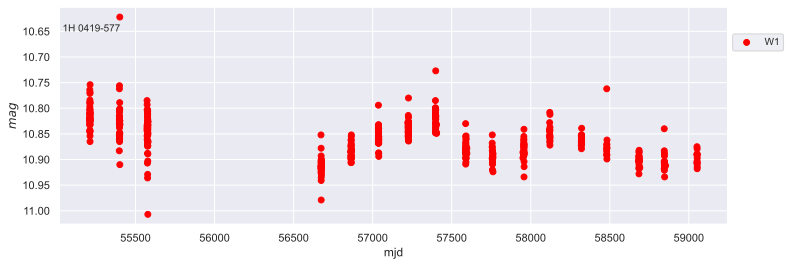

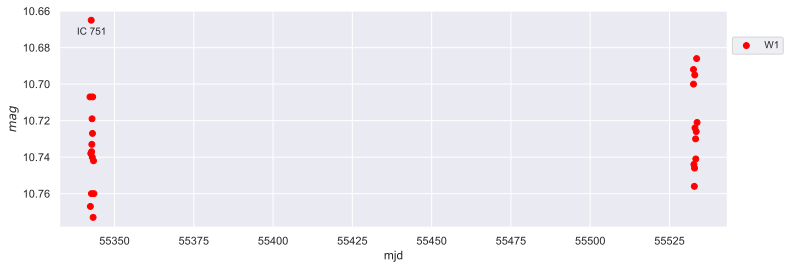

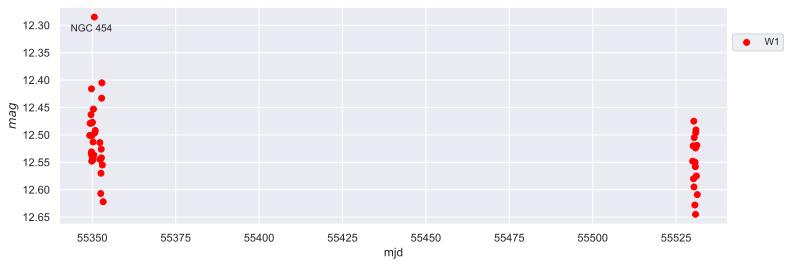

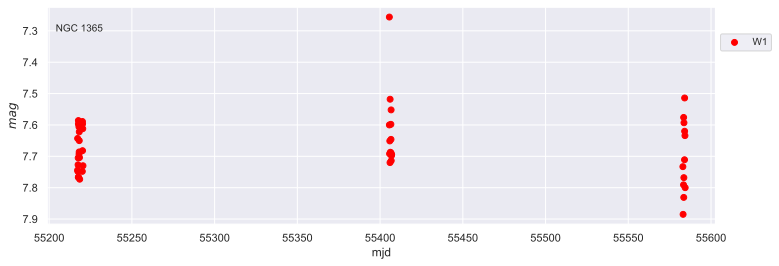

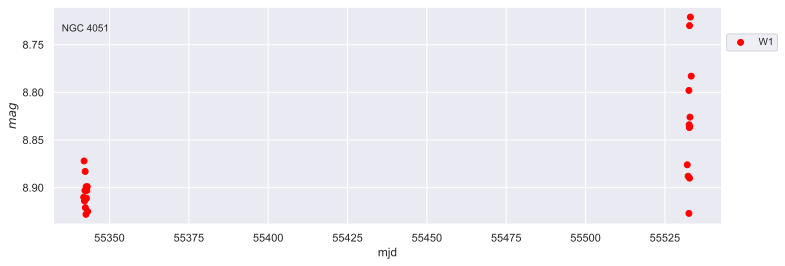

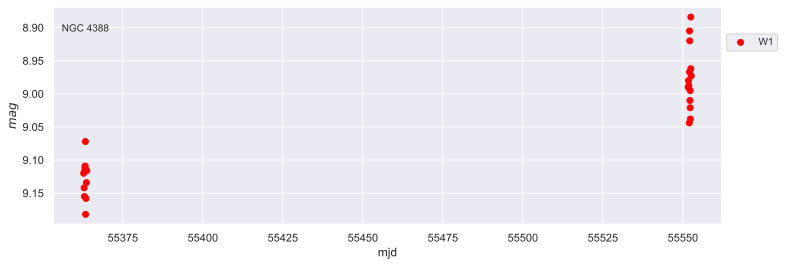

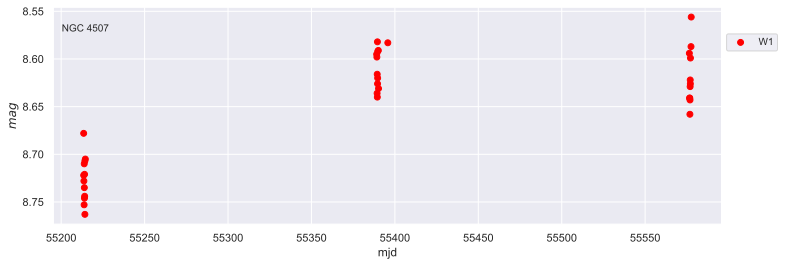

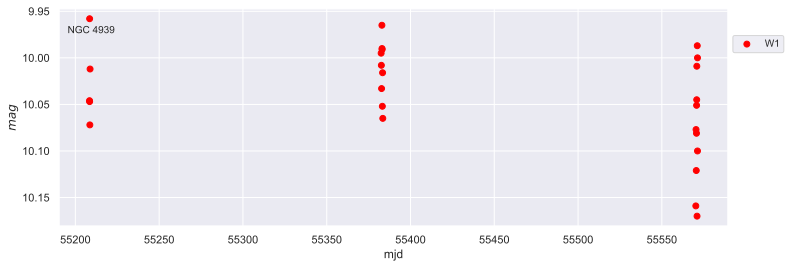

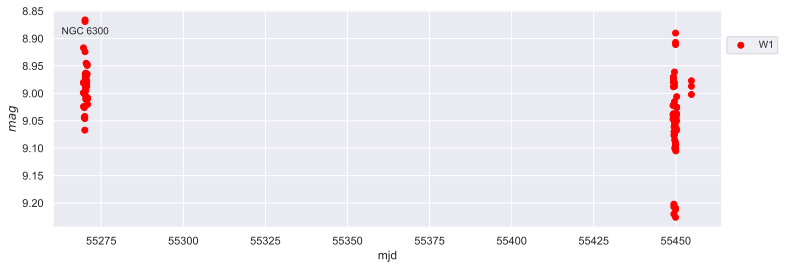

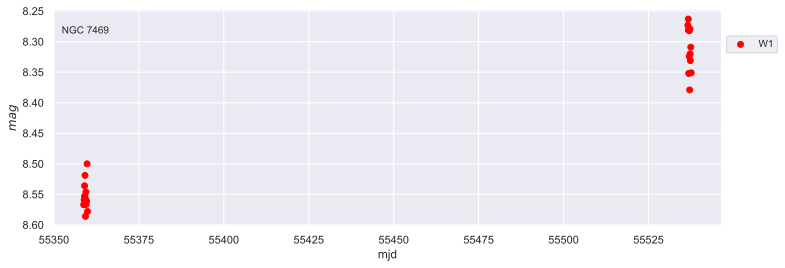

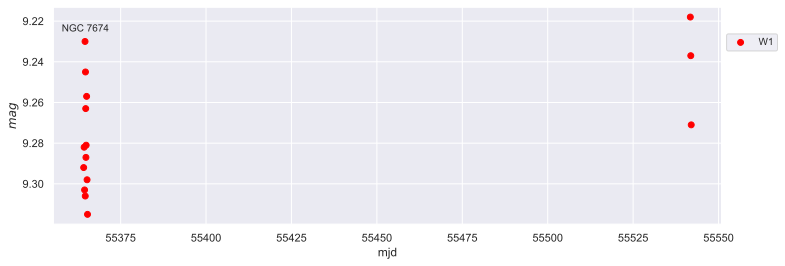

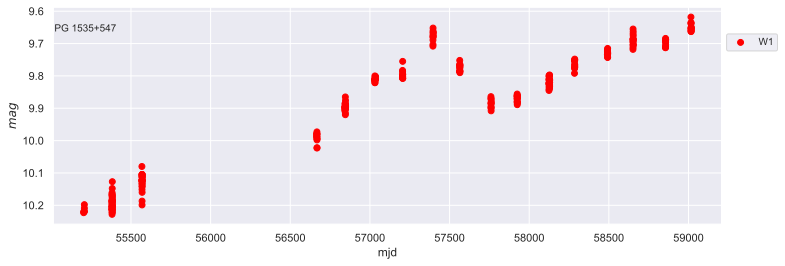

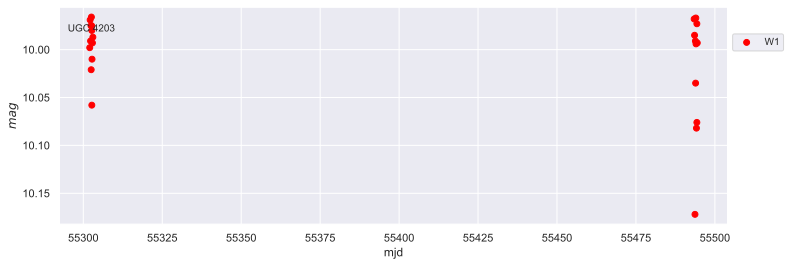

In [159]:
for index_test in range(len(typeB['Name'])):
    name_test=typeB['Name'][index_test]
    print(name_test)
    search_name=name_test.replace(' ','') 
    save_name=name_test

    data_test_neo=pd.read_csv('./CLAGN_wise_data/wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]  
    data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('./CLAGN_wise_data/wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    save_lc_img_path='/Users/brettlv/Downloads/CLAGN_statistic_plot/CLAGN/typeB/WISE_CLAGN_lc_w1_%s.png'%save_name
    if not os.path.exists(save_lc_img_path):
    
        fig = plt.figure(figsize=(12,4))
        fig.subplots_adjust(hspace=0.0, wspace = 0.0)
        ax = fig.add_subplot(111)

        ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
        ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')


        #ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
        #ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
        handles, labels = ax.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
              loc=2,fontsize=10)

        bottom, top = plt.ylim() 
        plt.ylim(top,bottom)

        plt.xlabel('mjd')
        plt.ylabel(r'$mag$')

        ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
        plt.savefig(save_lc_img_path,dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    



## CLAGN_lc_all

In [ ]:
for index_test in range(len(CLAGN_statistic_2021_liu['Name'])):
    name_test=CLAGN_statistic_2021_liu['Name'][index_test]
    print(name_test)
    search_name=name_test.replace(' ','') 
    save_name=name_test

    data_test_neo=pd.read_csv('wise_%s_neo.csv'%save_name)
    data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
    data_test_neo=data_test_neo[data_test_neo['w1mpro']<15]
    data_test_neo=data_test_neo[data_test_neo['w2mpro']<13]  
    data_test_neo=data_test_neo[data_test_neo['w1rchi2']<2]
    #data_test_neo=data_test_neo[data_test_neo['w2rchi2']<2]
    
    data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
    #print(len(data_test_neo))
    data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                                 'w1sigmpro','w2sigmpro',
                                 ]].sort_values('mjd'))

    data_test_neo=data_test_neo.reset_index(drop=True)
    #print(data_test_neo.columns)

    data_test_mep=pd.read_csv('wise_%s_mep.csv'%save_name)
    data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
    data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
    #data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
    data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
    data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]

    #print(len(data_test_mep))
    data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                         'w1sigmpro_ep','w2sigmpro_ep',
                                         ]].sort_values('mjd'))

    data_test_mep=data_test_mep.reset_index(drop=True)
    #print(data_test_mep.columns)
    save_lc_img_path='/Users/brettlv/Downloads/CLAGN_statistic_plot/CLAGN/WISE_CLAGN_lc_w1_%s.png'%save_name
    if not os.path.exists(save_lc_img_path):
    
        fig = plt.figure(figsize=(12,4))
        fig.subplots_adjust(hspace=0.0, wspace = 0.0)
        ax = fig.add_subplot(111)

        ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
        ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')


        #ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
        #ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
        handles, labels = ax.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
              loc=2,fontsize=10)

        bottom, top = plt.ylim() 
        plt.ylim(top,bottom)

        plt.xlabel('mjd')
        plt.ylabel(r'$mag$')

        ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
        plt.savefig(save_lc_img_path,dpi=400, transparent=False, bbox_inches='tight')
    #plt.semilogy()    



In [ ]:
index_test=0
name_test=CLAGN_statistic_2021_liu['Name'][index_test]
print(name_test)
search_name=name_test.replace(' ','') 
save_name=name_test

data_test_neo=pd.read_csv('wise_%s_neo.csv'%save_name)
data_test_neo=data_test_neo[data_test_neo['w1mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2mpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w1sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['w2sigmpro'].notnull()]
data_test_neo=data_test_neo[data_test_neo['qual_frame']>5]
print(len(data_test_neo))
data_test_neo=(data_test_neo.loc[:, ['mjd', 'w1mpro','w2mpro',
                             'w1sigmpro','w2sigmpro',
                             ]].sort_values('mjd'))

data_test_neo=data_test_neo.reset_index(drop=True)
print(data_test_neo.columns)

data_test_mep=pd.read_csv('wise_%s_mep.csv'%save_name)
data_test_mep=data_test_mep[data_test_mep['w1mpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w2mpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w1sigmpro_ep'].notnull()]
data_test_mep=data_test_mep[data_test_mep['w2sigmpro_ep'].notnull()]
#data_test_mep=data_test_mep[data_test_mep['qual_frame']>5]
data_test_mep=data_test_mep[data_test_mep['qi_fact']>0]
data_test_mep=data_test_mep[data_test_mep['saa_sep']>0]
    
print(len(data_test_mep))
data_test_mep=(data_test_mep.loc[:, ['mjd', 'w1mpro_ep','w2mpro_ep',
                                     'w1sigmpro_ep','w2sigmpro_ep',
                                     ]].sort_values('mjd'))

data_test_mep=data_test_mep.reset_index(drop=True)
print(data_test_mep.columns)


fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

#ax.scatter(data_test_neo['mjd'],data_test_neo['w1mpro'],color='red',label='W1')
ax.scatter(data_test_mep['mjd'],data_test_mep['w1mpro_ep'],color='red',label='W1')


#ax.scatter(data_test_neo['mjd'],data_test_neo['w2mpro'],color='blue',label='W2')
ax.scatter(data_test_mep['mjd'],data_test_mep['w2mpro_ep'],color='blue',label='W2')
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.0, 0.9),ncol=1,
      loc=2,fontsize=10)

bottom, top = plt.ylim() 
plt.ylim(top,bottom)

plt.xlabel('mjd')
plt.ylabel(r'$mag$')
plt.xlim(55365,55390)
ax.text(0.05, 0.9,name_test , horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)


# type A B

In [51]:
typeA=CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['type'].str.contains('A')]
typeB=CLAGN_statistic_2021_liu[CLAGN_statistic_2021_liu['type'].str.contains('B')]

typeA=typeA.reset_index(drop=True)
typeB=typeB.reset_index(drop=True)

In [ ]:
len(typeA),len(typeB)

In [ ]:
len(CLAGN_statistic_2021_liu)

In [ ]:
typeB

## mean and sigma_m

In [ ]:
typeA.columns

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(typeA['mean_m_w1_neo'],typeA['sigma_m_w1_neo'],color='red',marker='.',label='Optical_w1')
plt.scatter(typeB['mean_m_w1_neo'],typeB['sigma_m_w1_neo'],color='black',marker='.',label='Xray_w1')

plt.scatter(typeA['mean_m_w2_neo'],typeA['sigma_m_w2_neo'],color='red',marker='+',label='Optical_w2')
plt.scatter(typeB['mean_m_w2_neo'],typeB['sigma_m_w2_neo'],color='black',marker='+',label='Xray_w2')

ax.legend( bbox_to_anchor=(0.5, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)
set_ax_tick(ax)
plt.xlabel('mean mag')
plt.ylabel(r'$\sigma_m$')
bottom,top=plt.xlim()
plt.xlim(top,bottom)
#plt.xlim(18,0)

#ax.text(0.1, 0.9, 'w1_neo', horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.scatter(typeA['mean_m_w1_neo'],typeA['sigma_m_w1_neo'],color='red',marker='.',label='Optical')
plt.scatter(typeB['mean_m_w1_neo'],typeB['sigma_m_w1_neo'],color='black',marker='.',label='Xray')

#plt.scatter(typeA['mean_m_w2_neo'],typeA['sigma_m_w2_neo'],color='red',marker='+')
#plt.scatter(typeB['mean_m_w2_neo'],typeB['sigma_m_w2_neo'],color='black',marker='+',label='w2')

ax.legend( bbox_to_anchor=(0.0, 0.9),
          loc=2, numpoints=1,ncol=1,fontsize=11.)
plt.xlabel('mean mag w1')
plt.ylabel(r'$\sigma_m w1$')
bottom,top=plt.xlim()
plt.xlim(top,bottom)

#ax.text(0.1, 0.9, 'w1_neo', horizontalalignment = 'center', verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
#plt.semilogy()

### subplot

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)

size=5

ax = fig.add_subplot(221)
ax.scatter(typeA['mean_m_w1_neo'],typeA['mean_m_w2_neo'],s=size,color='red',label='Optical')
ax.scatter(typeB['mean_m_w1_neo'],typeB['mean_m_w2_neo'],s=size,color='black',label='Xray')
ax.scatter(LLAGN['mean_m_w1_neo'],LLAGN['mean_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)


ax.scatter(Extreme_QSO_select['mean_m_w1_neo'],Extreme_QSO_select['mean_m_w2_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)

ax.scatter(QSO_select['mean_m_w1_neo'],QSO_select['mean_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)




ax.set_xlabel(r'W1 (mag)')
ax.set_ylabel(r'W2 (mag)')
set_ax_tick(ax)
ax.legend( bbox_to_anchor=(0.01, 0.95),
          loc=2, numpoints=1,ncol=1,fontsize=11.)




ax = fig.add_subplot(224)
ax.scatter(typeA['mean_m_w1_neo']-typeA['mean_m_w2_neo'],typeA['mean_m_w1_neo'],s=size,color='red',label='O')
ax.scatter(typeB['mean_m_w1_neo']-typeB['mean_m_w2_neo'],typeB['mean_m_w1_neo'],s=size,color='black',label='X')
ax.scatter(LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],LLAGN['mean_m_w1_neo'],
           s=size,color='grey',marker='*',alpha=0.5,zorder=0)

ax.scatter(Extreme_QSO_select['mean_m_w1_neo']-Extreme_QSO_select['mean_m_w2_neo'],Extreme_QSO_select['mean_m_w1_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,zorder=1)

ax.scatter(QSO_select['mean_m_w1_neo']-QSO_select['mean_m_w2_neo'],QSO_select['mean_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)




ax.set_xlabel(r'W1-W2')
ax.set_ylabel(r'W1')
set_ax_tick(ax)

ax = fig.add_subplot(222)
ax.scatter(typeA['mean_m_w1_neo']-typeA['mean_m_w2_neo'],typeA['mean_m_w2_neo'],s=size,color='red',label='O')
ax.scatter(typeB['mean_m_w1_neo']-typeB['mean_m_w2_neo'],typeB['mean_m_w2_neo'],s=size,color='black',label='X')
ax.scatter(LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],LLAGN['mean_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,zorder=0)

ax.scatter(Extreme_QSO_select['mean_m_w1_neo']-Extreme_QSO_select['mean_m_w2_neo'],Extreme_QSO_select['mean_m_w2_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,zorder=0)


ax.scatter(QSO_select['mean_m_w1_neo']-QSO_select['mean_m_w2_neo'],QSO_select['mean_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)




ax.set_xlabel(r'W1-W2')
ax.set_ylabel(r'W2')

set_ax_tick(ax)
fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_color_subplot.png',
            dpi=400, transparent=False, bbox_inches='tight')



In [ ]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=5
ax = fig.add_subplot(231)
x=np.linspace(0,1,10)
ax.plot(x,x,ls=':')
ax.scatter(typeA['sigma_m_w1_neo'],typeA['sigma_m_w2_neo'],s=size,color='red',label='Optical')
ax.scatter(typeB['sigma_m_w1_neo'],typeB['sigma_m_w2_neo'],s=size,color='black',label='blue')
ax.scatter(LLAGN['sigma_m_w1_neo'],LLAGN['sigma_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax.scatter(Extreme_QSO_select['sigma_m_w1_neo'],Extreme_QSO_select['sigma_m_w2_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)

ax.scatter(QSO_select['sigma_m_w1_neo'],QSO_select['sigma_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)



ax.set_xlabel(r'$\sigma_m$ w1_neo')
ax.set_ylabel(r'$\sigma_m$ w2_neo')
set_ax_tick(ax)
ax.legend( bbox_to_anchor=(1.01, 0.95),
          loc=2, numpoints=1,ncol=1,fontsize=11.)


ax = fig.add_subplot(232)
ax.scatter(typeA['mean_m_w2_neo'],typeA['sigma_m_w2_neo'],s=size,color='red')
ax.scatter(typeB['mean_m_w2_neo'],typeB['sigma_m_w2_neo'],s=size,color='blue')
ax.scatter(LLAGN['mean_m_w2_neo'],LLAGN['sigma_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax.scatter(Extreme_QSO_select['mean_m_w2_neo'],Extreme_QSO_select['sigma_m_w2_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)

ax.scatter(QSO_select['mean_m_w2_neo'],QSO_select['sigma_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)

           

ax.set_xlabel(r'W2')
ax.set_ylabel(r'$\sigma_m$ w2_neo')
set_ax_tick(ax)

ax = fig.add_subplot(233)
ax.scatter(typeA['mean_m_w1_neo']-typeA['mean_m_w2_neo'],typeA['sigma_m_w2_neo'],s=size,color='red')
ax.scatter(typeB['mean_m_w1_neo']-typeB['mean_m_w2_neo'],typeB['sigma_m_w2_neo'],s=size,color='blue')
ax.scatter(LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],LLAGN['sigma_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)
ax.scatter(Extreme_QSO_select['mean_m_w1_neo']-Extreme_QSO_select['mean_m_w2_neo'],
           Extreme_QSO_select['sigma_m_w2_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)

ax.scatter(QSO_select['mean_m_w1_neo']-QSO_select['mean_m_w2_neo'],
           QSO_select['sigma_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


ax.set_xlabel(r'W1-W2')
ax.set_ylabel(r'$\sigma_m$ w2_neo')
set_ax_tick(ax)


ax = fig.add_subplot(235)
ax.scatter(typeA['mean_m_w1_neo'],typeA['sigma_m_w1_neo'],s=size,color='red')
ax.scatter(typeB['mean_m_w1_neo'],typeB['sigma_m_w1_neo'],s=size,color='blue')

ax.scatter(LLAGN['mean_m_w1_neo'],LLAGN['sigma_m_w1_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax.scatter(Extreme_QSO_select['mean_m_w1_neo'],Extreme_QSO_select['sigma_m_w1_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)

ax.scatter(QSO_select['mean_m_w1_neo'],QSO_select['sigma_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


ax.set_xlabel(r'W1')
ax.set_ylabel(r'$\sigma_m$ w1_neo')
set_ax_tick(ax)

ax = fig.add_subplot(236)
ax.scatter(typeA['mean_m_w1_neo']-typeA['mean_m_w2_neo'],typeA['sigma_m_w1_neo'],s=size,color='red')
ax.scatter(typeB['mean_m_w1_neo']-typeB['mean_m_w2_neo'],typeB['sigma_m_w1_neo'],s=size,color='blue')
ax.scatter(LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],LLAGN['sigma_m_w1_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)
ax.scatter(Extreme_QSO_select['mean_m_w1_neo']-Extreme_QSO_select['mean_m_w2_neo'],
           Extreme_QSO_select['sigma_m_w1_neo'],
           s=size,color='cyan',marker='*',alpha=0.5,label='EVQ',zorder=1)
ax.scatter(QSO_select['mean_m_w1_neo']-QSO_select['mean_m_w2_neo'],
           QSO_select['sigma_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


ax.set_xlabel(r'W1-W2')
ax.set_ylabel(r'$\sigma_m$ w1_neo')
set_ax_tick(ax)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_variability_subplot.png',
            dpi=400, transparent=False, bbox_inches='tight')



### sigma_m and mass

In [ ]:
typeA_mass=typeA.copy()
typeA_mass=typeA_mass[typeA['logM']!=' - ']
typeA_mass=typeA_mass.reset_index(drop=True)

typeB_mass=typeB.copy()
typeB_mass=typeB_mass[typeB['logM']!=' - ']
typeB_mass=typeB_mass.reset_index(drop=True)

In [ ]:
QSO.columns

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=7
ax = fig.add_subplot(221)
#x=np.linspace(0,1,10)
#ax.plot(x,x,ls=':')

ax.scatter(typeA_mass['logM'],typeA_mass['sigma_m_w1_neo'],
           s=size,color='red',marker='.',label='Optical')
ax.scatter(typeB_mass['logM'],typeB_mass['sigma_m_w1_neo'],
           s=size,color='blue',marker='+',label='Xray')

'''ax.scatter(typeA_mass['logM'],typeA_mass['sigma_m_w2_neo'],
           s=size,color='red',marker='*',label='O_w2')
ax.scatter(typeB_mass['logM'],typeB_mass['sigma_m_w2_neo'],
           s=size,color='black',marker='*',label='X_2')
ax.scatter(LLAGN['lg(MBH/Msun)'],LLAGN['sigma_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN_w2',zorder=0)           
'''
ax.scatter(LLAGN['lg(MBH/Msun)'],LLAGN['sigma_m_w1_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)

ax.scatter(QSO['lg(L_Mbh)'],QSO['sigma_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)

for index,lmass in enumerate(Extreme_QSO_select['logBH']):
    if lmass>0:
        ax.scatter(Extreme_QSO_select.loc[index,'logBH'],
                   Extreme_QSO_select.loc[index,'sigma_m_w1_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)


ax.set_xlabel(r'$log M_{BH}$ ')
ax.set_ylabel(r'$\sigma_m w1$')
set_ax_tick(ax)

#ax.legend( bbox_to_anchor=(0.01, 0.95),loc=2, numpoints=1,ncol=1,fontsize=9.)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
#by_label = OrderedDict(zip(labels, hdl)) 

labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.95),
          loc=2, numpoints=1,ncol=1,fontsize=11.)


ax = fig.add_subplot(223)
ax.scatter(typeA_mass['logM'],typeA_mass['mean_m_w1_neo']-typeA_mass['mean_m_w2_neo'],
           s=size,color='red',marker='.',label='Optical')
ax.scatter(typeB_mass['logM'],typeB_mass['mean_m_w1_neo']-typeB_mass['mean_m_w2_neo'],
           s=size,color='blue',marker='+',label='Xray')

'''ax.scatter(typeA_mass['logM'],typeA_mass['mean_m_w1_neo']-typeA_mass['mean_m_w2_neo'],
           s=size,color='red',marker='*',label='O')
ax.scatter(typeB_mass['logM'],typeB_mass['mean_m_w1_neo']-typeB_mass['mean_m_w2_neo'],
           s=size,color='black',marker='*',label='X')
ax.scatter(LLAGN['lg(MBH/Msun)'],LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)
'''

ax.scatter(LLAGN['lg(MBH/Msun)'],
           LLAGN['mean_m_w1_neo']-LLAGN['mean_m_w2_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)


ax.scatter(QSO['lg(L_Mbh)'],
           QSO['mean_m_w1_neo']-QSO['mean_m_w2_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


for index,lmass in enumerate(Extreme_QSO_select['logBH']):
    if lmass>0:        
        ax.scatter(Extreme_QSO_select.loc[index,'logBH'],
           Extreme_QSO_select.loc[index,'mean_m_w1_neo']-Extreme_QSO_select.loc[index,'mean_m_w2_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)


ax.set_xlabel(r'$log M_{BH}$ ')
ax.set_ylabel(r'$W1-W2$')
set_ax_tick(ax)



ax = fig.add_subplot(222)

ax.scatter(LLAGN['lg(Lbol/LEdd)'],LLAGN['sigma_m_w1_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)
ax.scatter(QSO['log(Lbol/Ledd)'],QSO['sigma_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)
for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'sigma_m_w1_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)


ax.set_xlabel(r'log(Lbol/Ledd)')
ax.set_ylabel(r'$\sigma_m w1$')
set_ax_tick(ax)
set_ax_locator(ax,xma=1.0,xmi=0.5,yma=0.5,ymi=0.25)

ax_4 = fig.add_subplot(224)

ax_4.scatter(LLAGN['lg(Lbol/LEdd)'],LLAGN['mean_m_w1_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax_4.scatter(QSO['log(Lbol/Ledd)'],QSO['mean_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax_4.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'mean_m_w1_neo'],
                s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)


ax_4.set_xlabel(r'log(Lbol/Ledd)')
ax_4.set_ylabel(r'w1')
bottom,top=ax_4.set_ylim()
ax_4.set_ylim(top,bottom)
set_ax_tick(ax_4)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_variability_subplot_mass_ledd.png',
            dpi=400, transparent=False, bbox_inches='tight')




### sigma m w1 Ledd

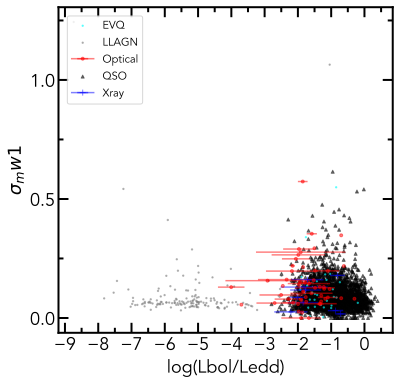

In [70]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=9
ax = fig.add_subplot(111)

ax.scatter(LLAGN_select['lg(Lbol/LEdd)'],LLAGN_select['sigma_m_w1_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)
ax.scatter(QSO_select['log(Lbol/Ledd)'],QSO_select['sigma_m_w1_neo'],
           s=size,color='black',marker='^',alpha=0.5,label='QSO',zorder=0)

for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'sigma_m_w1_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)
        
CLAGN_select=CLAGN_statistic_2021_liu
for index,name in enumerate(CLAGN_select['Name']):
    if CLAGN_select.loc[index,'type'].find('A')>0:
        color='red'
        marker='.'
        label='Optical'
        
    else:
        color='blue'
        marker='+'
        label='Xray'
    
    CLAGN_leddrate=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['Name'].str.strip()==name.strip()]
    #print(index,name,len(CLAGN_leddrate))
    if len(CLAGN_leddrate)>0:
        minleddrate=min(np.log10(CLAGN_leddrate['Lbol/LEdd']))
        maxleddrate=max(np.log10(CLAGN_leddrate['Lbol/LEdd']))     
        ax.errorbar(x=(minleddrate+maxleddrate)/2,y=CLAGN_select.loc[index,'sigma_m_w1_neo'],
                xerr=(maxleddrate-minleddrate)/2,
                color=color,marker=marker,alpha=0.5,label=label,zorder=1)

        
ax.set_xlabel(r'log(Lbol/Ledd)')
ax.set_ylabel(r'$\sigma_m w1$')
set_ax_tick(ax)
set_ax_locator(ax,xma=1.0,xmi=0.5,yma=0.5,ymi=0.25)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
#by_label = OrderedDict(zip(labels, hdl)) 

labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_variability_ledd.png',
            dpi=400, transparent=False, bbox_inches='tight')



### W1-W2 Ledd

/Users/brettlv/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


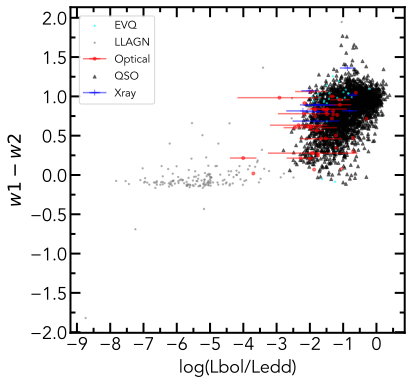

In [68]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=9
ax = fig.add_subplot(111)

ax.scatter(LLAGN_select['lg(Lbol/LEdd)'],LLAGN_select['mean_m_w1_neo']-LLAGN_select['mean_m_w2_neo'],
           s=size,color='grey',marker='.',alpha=0.5,label='LLAGN',zorder=0)
ax.scatter(QSO_select['log(Lbol/Ledd)'],QSO_select['mean_m_w1_neo']-QSO_select['mean_m_w2_neo'],
           s=size,color='black',marker='^',alpha=0.5,label='QSO',zorder=0)

for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'mean_m_w1_neo']-Extreme_QSO_select.loc[index,'mean_m_w2_neo'],
           s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)
        
#CLAGN_select=CLAGN_statistic_2021_liu
for index,name in enumerate(CLAGN_select['Name']):
    if CLAGN_select.loc[index,'type'].find('A')>0:
        color='red'
        marker='.'
        label='Optical'
        
    else:
        color='blue'
        marker='+'
        label='Xray'
    
    CLAGN_leddrate=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['Name'].str.strip()==name.strip()]
    #print(index,name,len(CLAGN_leddrate))
    if len(CLAGN_leddrate)>0:
        minleddrate=min(np.log10(CLAGN_leddrate['Lbol/LEdd']))
        maxleddrate=max(np.log10(CLAGN_leddrate['Lbol/LEdd']))     
        ax.errorbar(x=(minleddrate+maxleddrate)/2,y=CLAGN_select.loc[index,'mean_m_w1_neo']-CLAGN_select.loc[index,'mean_m_w2_neo'],
                xerr=(maxleddrate-minleddrate)/2,
                color=color,marker=marker,alpha=0.5,label=label,zorder=1)

        
ax.set_xlabel(r'log(Lbol/Ledd)')
ax.set_ylabel(r'$w1-w2$')
set_ax_tick(ax)
set_ax_locator(ax,xma=1.0,xmi=0.5,yma=0.5,ymi=0.25)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
#by_label = OrderedDict(zip(labels, hdl)) 

labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_variability_W1-W2_ledd.png',
            dpi=400, transparent=False, bbox_inches='tight')



In [67]:
print(len(LLAGN_select))
print(len(Extreme_QSO_select))
print(len(QSO_select))
print(len(CLAGN_select))

164
30
3140
82


### Lw1 Leddrate

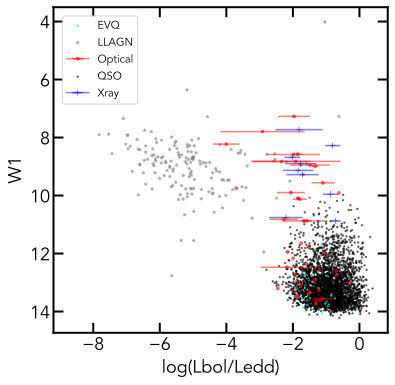

In [69]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.3, wspace = 0.35)
size=9

ax_4 = fig.add_subplot(111)

ax_4.scatter(LLAGN_select['lg(Lbol/LEdd)'],LLAGN_select['mean_m_w1_neo'],
           s=size,color='grey',marker='*',alpha=0.5,label='LLAGN',zorder=0)

ax_4.scatter(QSO_select['log(Lbol/Ledd)'],QSO_select['mean_m_w1_neo'],
           s=size,color='black',marker='.',alpha=0.5,label='QSO',zorder=0)


for index,ledd in enumerate(Extreme_QSO_select['logEdd']):
    if ledd!=-999.00:
        ax_4.scatter(Extreme_QSO_select.loc[index,'logEdd'],
                   Extreme_QSO_select.loc[index,'mean_m_w1_neo'],
                s=size,color='cyan',marker='.',alpha=0.5,label='EVQ',zorder=1)
        
for index,name in enumerate(CLAGN_select['Name']):
    if CLAGN_select.loc[index,'type'].find('A')>0:
        color='red'
        marker='.'
        label='Optical'
        
    else:
        color='blue'
        marker='+'
        label='Xray'
    
    CLAGN_leddrate=CLAGN_statistic_2021_liu_Leddrate[CLAGN_statistic_2021_liu_Leddrate['Name'].str.strip()==name.strip()]
    #print(index,name,len(CLAGN_leddrate))
    if len(CLAGN_leddrate)>0:
        minleddrate=min(np.log10(CLAGN_leddrate['Lbol/LEdd']))
        maxleddrate=max(np.log10(CLAGN_leddrate['Lbol/LEdd']))     
        ax_4.errorbar(x=(minleddrate+maxleddrate)/2,y=CLAGN_select.loc[index,'mean_m_w1_neo'],
                xerr=(maxleddrate-minleddrate)/2,
                color=color,marker=marker,alpha=0.5,label=label,zorder=1)
        
handles, labels = ax_4.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
#by_label = OrderedDict(zip(labels, hdl)) 

labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))
ax_4.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)


ax_4.set_xlabel(r'log(Lbol/Ledd)')
ax_4.set_ylabel(r'W1')
bottom,top=ax_4.set_ylim()
ax_4.set_ylim(top,bottom)
set_ax_tick(ax_4)

fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_leddrate_w1.png',
            dpi=400, transparent=False, bbox_inches='tight')


In [ ]:
CLAGN_statistic_2021_liu_Leddrate['Name'][0].strip()==CLAGN_statistic_2021_liu['Name'][0].strip()

In [ ]:
CLAGN_statistic_2021_liu_Leddrate['Name'][0],CLAGN_statistic_2021_liu['Name'][0].strip()

## mean AB

In [ ]:
np.mean(CLAGN_statistic_2021_liu['sigma_m_w1_neo']),np.mean(CLAGN_statistic_2021_liu['sigma_m_w2_neo'])

In [ ]:
np.mean(typeA['sigma_m_w1_neo']),np.mean(typeB['sigma_m_w1_neo']),

In [ ]:
np.mean(typeA['sigma_m_w2_neo']),np.mean(typeB['sigma_m_w2_neo']),

In [ ]:
np.mean(typeA['mean_m_w1_neo']),np.mean(typeB['mean_m_w1_neo']),

In [ ]:
np.mean(typeA['mean_m_w2_neo']),np.mean(typeB['mean_m_w2_neo']),

In [ ]:
np.mean(typeA['sigma_m_w1_neo']),np.mean(typeA['sigma_m_w2_neo'])

In [ ]:
np.mean(typeB['sigma_m_w1_neo']),np.mean(typeB['sigma_m_w2_neo'])

## type B

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)
x=np.linspace(0,0.3,10)
plt.plot(x,x)
plt.scatter(typeB['sigma_m_w1_neo'],typeB['sigma_m_w2_neo'])
plt.xlabel(r'$\sigma_m$ w1_neo')
plt.ylabel(r'$\sigma_m$ w2_neo')

In [ ]:
typeB_plot=typeB.copy()
typeB_plot=typeB_plot.reset_index(drop=True)

In [ ]:
typeB_plot

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(121)

for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
        
    ax.text(typeB.iloc[i]['mean_m_w1_neo'],typeB.iloc[i]['sigma_m_w1_neo'],
             typeB.iloc[i]['type1or2'],fontsize = 8)    
    ax.scatter(typeB.iloc[i]['mean_m_w1_neo'],typeB.iloc[i]['sigma_m_w1_neo'],
                color=color,marker=marker,
                label=label)

ax2 = fig.add_subplot(122)
for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
        
    ax2.text(typeB.iloc[i]['mean_m_w1_neo'],typeB.iloc[i]['sigma_m_w1_neo'],
             typeB.iloc[i]['Name'],fontsize = 8)    
    ax2.scatter(typeB.iloc[i]['mean_m_w1_neo'],typeB.iloc[i]['sigma_m_w1_neo'],
                color=color,marker=marker,
                label=label)
    

ax.set_xlabel('mean mag')
ax.set_ylabel(r'$\sigma_m$')
ax.set_xlim(18,0)
ax2.set_xlim(18,0)
ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',labelsize=0)
ax.text(0.1, 0.1, 'w1_neo', horizontalalignment = 'center', 
             verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.95),
          loc=2, numpoints=1,ncol=1,fontsize=11.)
#plt.semilogy()    

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(121)

for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
    ax.text(typeB.iloc[i]['mean_m_w2_neo'],typeB.iloc[i]['sigma_m_w2_neo'],
             typeB.iloc[i]['type1or2'],fontsize = 8)
    
    ax.scatter(typeB.iloc[i]['mean_m_w2_neo'],typeB.iloc[i]['sigma_m_w2_neo'],
                color=color,marker=marker,
                label=label)
    
ax2 = fig.add_subplot(122)
for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
    
    ax2.text(typeB.iloc[i]['mean_m_w2_neo'],typeB.iloc[i]['sigma_m_w2_neo'],
             typeB.iloc[i]['Name'],fontsize = 8)
    
    ax2.scatter(typeB.iloc[i]['mean_m_w2_neo'],typeB.iloc[i]['sigma_m_w2_neo'],
                color=color,marker=marker,
                label=label)
    
ax.set_xlabel('mean mag')
ax.set_ylabel(r'$\sigma_m$')
ax.set_xlim(18,4)
ax2.set_xlim(18,4)
ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',labelsize=0)

ax.text(0.1, 0.1, 'w2_neo', horizontalalignment = 'center', 
             verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)

handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.95),
          loc=2, numpoints=1,ncol=1,fontsize=11.)
#plt.semilogy()    

### Type1or2

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(121)

for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
    ax.text(type1or2,typeB.iloc[i]['sigma_m_w1_neo'],
             typeB.iloc[i]['Name'],fontsize = 8)
    
    ax.scatter(type1or2,typeB.iloc[i]['sigma_m_w1_neo'],
                color=color,marker=marker,
                label=label)
    
ax2 = fig.add_subplot(122)
for i in range(len(typeB_plot)):
    type1or2=float(typeB.iloc[i]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
    
    ax2.text(type1or2,typeB.iloc[i]['sigma_m_w2_neo'],
             typeB.iloc[i]['Name'],fontsize = 8)
    
    ax2.scatter(type1or2,typeB.iloc[i]['sigma_m_w2_neo'],
                color=color,marker=marker,
                label=label)
    
ax.set_xlabel('Type')
ax2.set_xlabel('Type')
ax.set_ylabel(r'$\sigma_m$')

ax.set_xlim(0,3)
ax2.set_xlim(0,3)
ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',labelsize=0)

ax.text(0.1, 0.1, 'w1_neo', horizontalalignment = 'center', 
             verticalalignment = 'center',transform = ax.transAxes, fontsize = 10)
ax2.text(0.1, 0.1, 'w2_neo', horizontalalignment = 'center', 
             verticalalignment = 'center',transform = ax2.transAxes, fontsize = 10)


handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.9),
          loc=2, numpoints=1,ncol=1,fontsize=11.)
#plt.semilogy()    

### plot_all

In [ ]:
#epsilon_s_w1=0.024
#epsilon_s_w2=0.028
#CLAGN_statistic_2021_liu['sigma_m_w1_neo']=-1
#CLAGN_statistic_2021_liu['sigma_m_w2_neo']=-1

fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

for index,i in enumerate(typeB['Name']):
    type1or2=float(typeB.iloc[index]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
          
    data=pd.read_csv('wise_%s_neo.csv'%i)
    data=data[data['w1mpro'].notnull()]
    data=data[data['w2mpro'].notnull()]
    data=data[data['w1sigmpro'].notnull()]
    data=data[data['w2sigmpro'].notnull()]
    data=data[data['qual_frame']>0]
    data=data.reset_index(drop=True)
    #data=data.fillna(0)
    x_label='w1mpro'
    xerr_label='w1sigmpro'
    y_label='w2mpro'
    yerr_label='w2sigmpro'   
    
    for d in range(len(data)):
        plt.scatter(data.iloc[d][x_label],data.iloc[d][y_label],
                color=color,marker=marker,
                label=label)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xlim(18,6)
plt.ylim(18,6)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.9),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

In [ ]:
#epsilon_s_w1=0.024
#epsilon_s_w2=0.028
#CLAGN_statistic_2021_liu['sigma_m_w1_neo']=-1
#CLAGN_statistic_2021_liu['sigma_m_w2_neo']=-1

fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

for index,i in enumerate(typeB['Name']):
    type1or2=float(typeB.iloc[index]['type1or2'].split(' ')[1])
    #print(type1or2)
    if type1or2>=1.9:
        color='black'
        label='Type 2'
        marker='*'
    else:
        color='black'
        label='Type 1'
        marker='o'
          
    data=pd.read_csv('wise_%s_neo.csv'%i)
    data=data[data['w1mpro'].notnull()]
    data=data[data['w2mpro'].notnull()]
    data=data[data['w1sigmpro'].notnull()]
    data=data[data['w2sigmpro'].notnull()]
    data=data[data['qual_frame']>0]
    data=data.reset_index(drop=True)
    #data=data.fillna(0)
    x_label='w1mpro'
    xerr_label='w1sigmpro'
    y_label='w2mpro'
    yerr_label='w2sigmpro'   
    
    for d in range(len(data)):
        plt.scatter(data.iloc[d][x_label]-data.iloc[d][y_label],data.iloc[d][x_label],
                color=color,marker=marker,s=size,
                label=label)

plt.xlabel('W1-W2')
plt.ylabel('W1')
#plt.xlim(18,6)
plt.ylim(18,6)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
hdl=handles
#hdl = [h[0] for h in handles]
# use them in the legend
by_label = OrderedDict(zip(labels, hdl)) 
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.6, 0.9),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

# hist

In [ ]:
from astropy.visualization import hist

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

hist(typeA['sigma_m_w1_neo'],ax=ax,
         bins=10,
         #bins ='freedman',
         color = 'red',
         density=True,
         zorder=1,histtype='step',
         label='optical CLAGN')

hist(typeB['sigma_m_w1_neo'],ax=ax,
         bins=10,
         #bins ='freedman',
         color = 'black',
         density=True,
         zorder=0,histtype='step',
         label='X-ray CLAGN')
   
#plt.hist(typeA['sigma_m_w1_neo'],color='red',label='optical CLAGN')
#plt.hist(typeB['sigma_m_w1_neo'],color='black',label='X-ray CLAGN')

ax.set_xlabel(r'intrinsic amplitude of variability ($\sigma_m$)')
plt.legend()

In [ ]:
typeA.columns

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace = 0.2)

label_bands=['W1_NEO','W2_NEO','W1_MEP','W2_MEP']
label_datas=['sigma_m_w1_neo','sigma_m_w2_neo','sigma_m_w1_mep','sigma_m_w2_mep']

for i,band in enumerate(label_bands):
    ax = fig.add_subplot(2, 2, i+1)
    
    ax.hist(typeA[label_datas[i]],
         bins=10,
         color = 'red',
         density=True,
         zorder=1,histtype='step',
         label='optical CLAGN')

    ax.hist(typeB[label_datas[i]],

         bins=10,
         color = 'black',
         zorder=2,histtype='step',
         label='X-ray CLAGN')
         #hist
#plt.hist(typeA['sigma_m_w1_neo'],color='red',label='optical CLAGN')
#plt.hist(typeB['sigma_m_w1_neo'],color='black',label='X-ray CLAGN')
    ax.text(0.7, 0.9, label_bands[i], horizontalalignment = 'center', 
             verticalalignment = 'center', transform = ax.transAxes, fontsize = 10)

plt.xlabel(r'intrinsic amplitude of variability ($\sigma_m$)')    
plt.legend(bbox_to_anchor=(0.27, 1.8),
          loc=2, numpoints=1,ncol=1, fontsize=9.)
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
fig.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/WISE_variability.png', 
            dpi=400, transparent=False, bbox_inches='tight')


    

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace = 0.2)

label_bands=['W1_NEO','W2_NEO','W1_MEP','W2_MEP']
label_datas=['sigma_m_w1_neo','sigma_m_w2_neo','sigma_m_w1_mep','sigma_m_w2_mep']

for i,band in enumerate(label_bands):
    ax = fig.add_subplot(2, 2, i+1)
    
    hist(typeA[label_datas[i]],ax=ax,
         #bins=15,
         #bins ='freedman',#blocks,scott,knuth
         bins='scott',
         color = 'red',
         density=True,
         zorder=1,histtype='step',
         label='optical CLAGN')

    hist(typeB[label_datas[i]],ax=ax,
         #bins=15,
         #bins ='freedman',
         bins='scott',
         color = 'black',
         density=True,
         zorder=2,histtype='step',
         label='X-ray CLAGN')
         #hist
#plt.hist(typeA['sigma_m_w1_neo'],color='red',label='optical CLAGN')
#plt.hist(typeB['sigma_m_w1_neo'],color='black',label='X-ray CLAGN')
    ax.text(0.8, 0.9, label_bands[i], horizontalalignment = 'center', 
             verticalalignment = 'center', transform = ax.transAxes, fontsize = 10)
    
plt.legend(bbox_to_anchor=(0.3, 1.8),
          loc=2, numpoints=1,ncol=1, fontsize=9.)

    

# sns scatter and hist

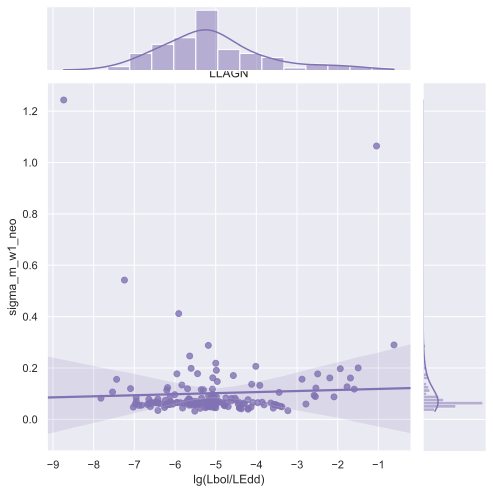

In [153]:

import seaborn as sns
sns.set_theme(style="darkgrid")


#LLAGN_select['lg(Lbol/LEdd)'],LLAGN_select['sigma_m_w1_neo'],

#tips = sns.load_dataset("tips")
g = sns.jointplot(x="lg(Lbol/LEdd)", y="sigma_m_w1_neo", data=LLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)
plt.title('LLAGN')
g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_LLAGN_sigma_m_W1_ledd')


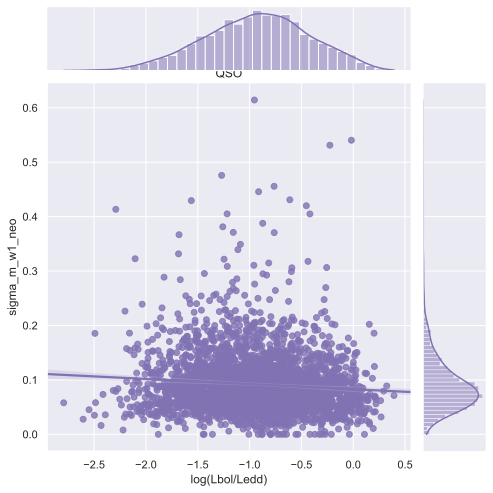

In [151]:
#QSO_select['log(Lbol/Ledd)'],QSO_select['sigma_m_w1_neo'],
g = sns.jointplot(x="log(Lbol/Ledd)", y="sigma_m_w1_neo", data=QSO_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)
plt.title('QSO')
g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_QSO_sigma_m_W1_ledd')


Text(0.5, 0.8, 'QSO')

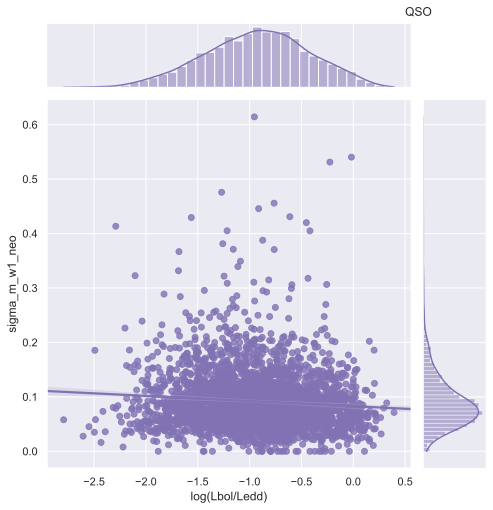

In [155]:
g = sns.jointplot(x="log(Lbol/Ledd)", y="sigma_m_w1_neo", data=QSO_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)
plt.text(0.5,0.8,'QSO',)

## CLAGN_select

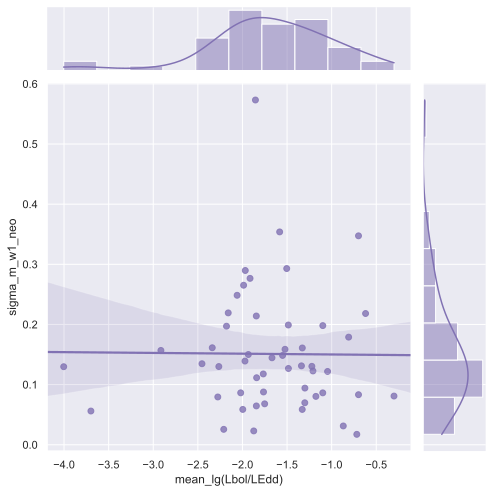

In [146]:
#QSO_select['log(Lbol/Ledd)'],QSO_select['sigma_m_w1_neo'],
#f, ax = plt.subplots(figsize=(5, 5))
g = sns.jointplot(x="mean_lg(Lbol/LEdd)", y="sigma_m_w1_neo", data=CLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7,)
g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_WISE_sigma_m_W1_ledd')


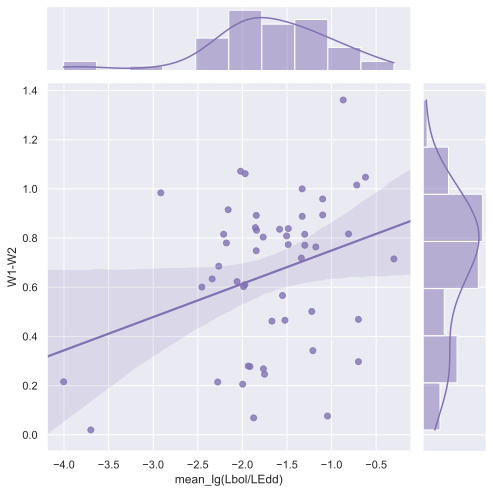

In [147]:
#QSO_select['log(Lbol/Ledd)'],QSO_select['sigma_m_w1_neo'],
#f, ax = plt.subplots(figsize=(5, 5))
g = sns.jointplot(x="mean_lg(Lbol/LEdd)", y="W1-W2", data=CLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7,)

g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_WISE_W1-W2_ledd')

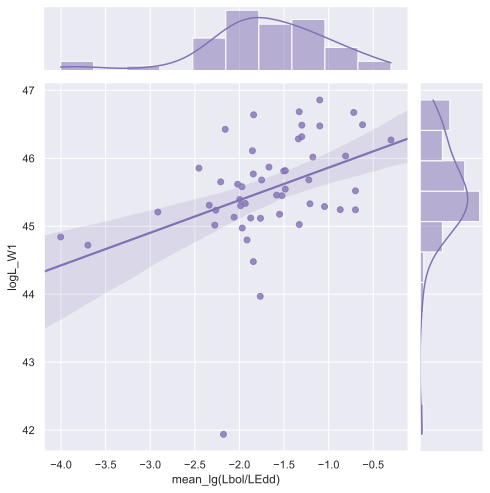

In [142]:
g = sns.jointplot(x="mean_lg(Lbol/LEdd)", y="logL_W1", data=CLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7,)

g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_WISE_LW1_ledd')

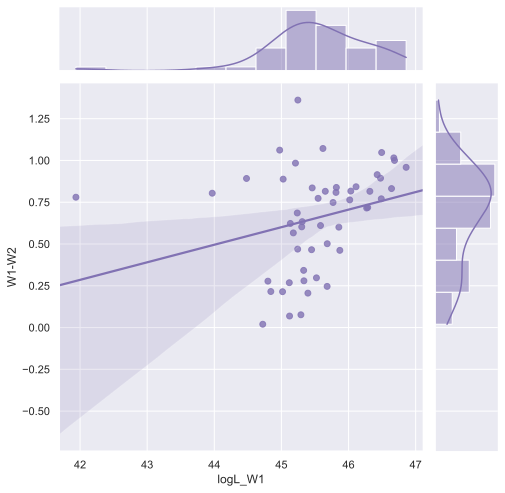

In [143]:
g = sns.jointplot(x="logL_W1", y="W1-W2", data=CLAGN_select,                  
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7,)

g.savefig('/Users/brettlv/Downloads/CLAGN_statistic_plot/sns_WISE_LW1_W1-W2')

## pearsonr spearmanr

In [ ]:
pearsonr(CLAGN_select['mean_lg(Lbol/LEdd)'],CLAGN_select['W1-W2'])

pearsonr(CLAGN_select['mean_m_w1_neo'],CLAGN_select['W1-W2'])

spearmanr(CLAGN_select['mean_lg(Lbol/LEdd)'],CLAGN_select['W1-W2'])

In [157]:
pearsonr(CLAGN_select['logL_W1'],CLAGN_select['sigma_m_w1_neo'])

(-0.05863434375626018, 0.6827568710589978)

In [144]:
pearsonr(CLAGN_select['logL_W1'],CLAGN_select['W1-W2'])

(0.2775600412585605, 0.04861299121792675)

In [145]:
pearsonr(CLAGN_select['logL_W1'],CLAGN_select['mean_lg(Lbol/LEdd)'])

(0.4146382104628369, 0.0024850624685243384)

## plt.bar

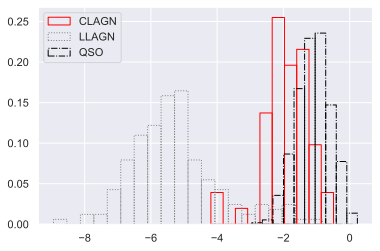

In [202]:
counts, bins = np.histogram(CLAGN_select['mean_lg(Lbol/LEdd)'])
plt.bar(bins[:-1],
        counts/len(CLAGN_select['mean_lg(Lbol/LEdd)']),
        bins[1]-bins[0],
        fill=False,
        label='CLAGN',edgecolor='red')


counts, bins = np.histogram(LLAGN_select['lg(Lbol/LEdd)'],bins=20)
plt.bar(bins[:-1],counts/len(LLAGN_select['lg(Lbol/LEdd)']),
        bins[1]-bins[0],
        fill=False,linestyle =':',
        label='LLAGN',edgecolor='grey')

counts, bins = np.histogram(QSO_select['log(Lbol/Ledd)'])
plt.bar(bins[:-1],counts/len(QSO_select['log(Lbol/Ledd)']),
        bins[1]-bins[0],
        fill=False,linestyle ='-.',
        label='QSO',edgecolor='black')
plt.legend()

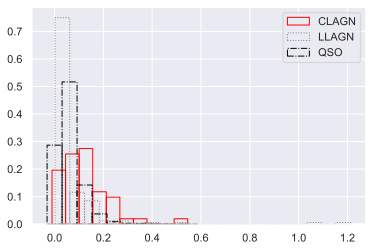

In [203]:
counts, bins = np.histogram(CLAGN_select['sigma_m_w1_neo'])
plt.bar(bins[:-1],
        counts/len(CLAGN_select['sigma_m_w1_neo']),
        bins[1]-bins[0],
        fill=False,
        label='CLAGN',edgecolor='red')


counts, bins = np.histogram(LLAGN_select['sigma_m_w1_neo'],bins=20)
plt.bar(bins[:-1],counts/len(LLAGN_select['sigma_m_w1_neo']),
        bins[1]-bins[0],
        fill=False,linestyle =':',
        label='LLAGN',edgecolor='grey')

counts, bins = np.histogram(QSO_select['sigma_m_w1_neo'])
plt.bar(bins[:-1],counts/len(QSO_select['sigma_m_w1_neo']),
        bins[1]-bins[0],
        fill=False,linestyle ='-.',
        label='QSO',edgecolor='black')
plt.legend()

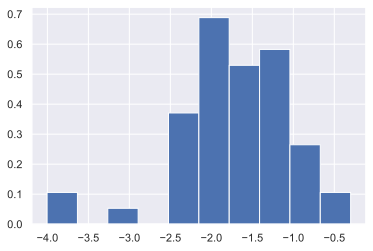

In [191]:
n, bins, etc=plt.hist(CLAGN_select['mean_lg(Lbol/LEdd)'],bins=10,density=True)

In [180]:
np.sum(n)

8.102014507663228

In [181]:
bins

array([-4.0038128 , -3.88038671, -3.75696061, -3.63353452, -3.51010843,
       -3.38668233, -3.26325624, -3.13983015, -3.01640405, -2.89297796,
       -2.76955187, -2.64612577, -2.52269968, -2.39927358, -2.27584749,
       -2.1524214 , -2.0289953 , -1.90556921, -1.78214312, -1.65871702,
       -1.53529093, -1.41186484, -1.28843874, -1.16501265, -1.04158656,
       -0.91816046, -0.79473437, -0.67130828, -0.54788218, -0.42445609,
       -0.30103   ])

In [183]:
np.diff(bins)

array([0.12342609, 0.12342609, 0.12342609, 0.12342609, 0.12342609,
       0.12342609, 0.12342609, 0.12342609, 0.12342609, 0.12342609,
       0.12342609, 0.12342609, 0.12342609, 0.12342609, 0.12342609,
       0.12342609, 0.12342609, 0.12342609, 0.12342609, 0.12342609,
       0.12342609, 0.12342609, 0.12342609, 0.12342609, 0.12342609,
       0.12342609, 0.12342609, 0.12342609, 0.12342609, 0.12342609])